In [1]:
import jax
import jax.numpy as jnp

from my_jax_utils import show_hlo_info

x = jnp.zeros((1024*128,2)) # Our probe array -- it uses 1MB

%load_ext autoreload
%autoreload 2

# Concepts:
* **GPU kernel** A GPU program that is executed parallel. Kernels cannot communicate directly
* **Device Arrays** An array that lives in GPU RAM -- usually this is the data that needs to be Input, Output or transfered between GPU kernels (but not the kernel-internal data.)
* **Graph** An arangement of several GPU kernels (+ their internal operations). The most important aspects are the boundaries between kernels
* **temporaries** Device arrays that need to be temporarily created and passed between kernels, but that may be discarded later
* **Fusing** Grouping of several operations as internal operations inside of a kernel / Merging of kernels to reduce the number of kernels launches
* **Fusion Barriers** Some operations prevent that code before and after them can be fused into one kernel, e.g. **FFTs**, **reduction operations** (jnp.sum), ... 

# An example Graph:

--------  Memory usage of f_sum_jax  ---------
code  : 5.1 kB
temp  : 512.0 kB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.5 MB


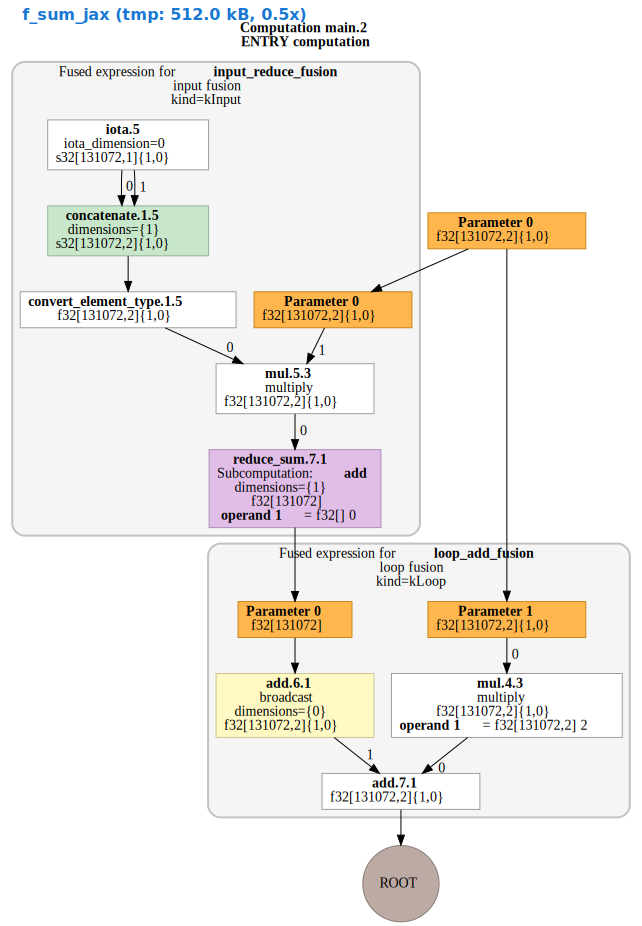

In [2]:
def kvec_mesh(N):
    return jnp.stack((jnp.arange(0, N), jnp.arange(0, N)), axis=-1)

def f_sum_jax(x):
    kvm = kvec_mesh(len(x))
    return x * 2 + jnp.sum(kvm * x, axis=1, keepdims=True)

show_hlo_info(jax.jit(f_sum_jax), x, width=500)

Above you can see an example of a Graph. The grey boxes indicate the boundaries of different kernels (Watch out to not confuse with "sub-computations" which are groups of kernels that appear in white boxes -- e.g. when using a loop). Inside of each kernel you can see all the operations that jax managed to "fuse" together. 

As a good guidline for optimizing both performance and memory usage assume:

* Computations inside of a kernel are basically for free (they need no memory and have negligible performance cost)

Therefore, you should be mainly conernced with

* How many kernels are used (because of memory bandwith)
* How many arrows appear between the kernels (each corresponding to a (temporary) device array -- increasing memory usage)

The graph above is sub-optimal, because we could have fused everything into one kernel if we wrote the program slightly differently (I will show this later later.)

# Important general considerations:

* Minimize temporary memory usage
* Minimize kernel launches / Maximize fusion
* Recomputing intermediates inside of a kernel is very cheap and almost always better than keeping temporaries in device memory.

Explanation: Most commonly GPU kernels are limited by the memory bandwith. The more data has to go through I/O, the worse the performance. If recalculation takes ~ 100 floating point operations, it is the better option performance wise (and of course saves memory). Optimizing memory therefore in most circumstances also optimizes performance.

* Some operations can create **fusion barriers** (e.g. `jnp.sum` or `jnp.fft.rfftn`)
* Using **jax.jit** in a sub-function does not create a fusion barrier (I.e. it is safe, but might waste tiny amount of compilation time)
* For cheap-to-calculate "constants" that you use many times (e.g. a kmesh), prefer to put them into functions that you call for each usage. This is especially important for achieveing recalculation inside of loops
* Sometimes we might need to trick jack into doing the recomputation rather than saving intermediates as temporaries
* Avoid constant folding at all costs!

# Important details
Throughout the notebook I will conduct many experiments for creating graphs to see what XLA can and can't do. Here I summarize the most important guidlines that I have extracted from those experiments. To appreciate these scroll down and try to understand the corresponding experiments


* **Avoid reduction operators** (if possible), they will generally not be fused. For example
```python
dot_prod = jnp.sum(x1*x2, axis=-1)                 # Bad for jax, prevents fusion in some cases
dot_prod = x1[...,0]*x2[...,0] + x1[...,1]*x2[...,1] + x1[...,2]*x2[...,2] # always allows fusion 
```
* Kernels with **aligned input and output** work effectively in place, not needing an additional temporary array. Therefore, they never have any impact on memory usage!
* Kernels where **input and output misalign** -- e.g. transposition kernels -- cannot work in place and generally need an additional temporary array.
* Often the same holds for external library kernels (e.g. ffts or sort)
* For **FFTs** with vectorial data prefer (3,N,N,N) layout over (N,N,N,3) layout, since (3,N,N,N) requires no transpositions on jax's side (internally they do, but whatever library jax calls does a better job with the memory usage)
* Jax loops can be partially **unrolled** to allow fusion. This may be worth it when the kernel that is looped over is very cheap (so that launch and I/O overhead dominate)
* XLA does **Common Sub Expression elimination** (CSE) that finds identical expressions. This is very useful in many scenarios, but it creates a nightmare for writing stable and memory-optimal code:
    - If the same expression appears more than once inside the same scope, jax identifies it and treats it as if it was the same tracer
    - If the computation is sufficiently complex, xla prefers to store it in a temporary device array from where it is first to where it is last needed (e.g. random numbers tend to be in this category)
    - If it is a reasonably simple expression, xla prefers to recalculate it locally inside of each kernel (no memory required) (e.g. `jnp.arange` or a kmesh Fourier Grid)
    - The boundary between the two cases is somewhat **unpredictable** and may be crossed because of tangible changes (e.g. in one example using  `jnp.sin` instead of `jnp.exp`).
    - The CSE seems to only apply inside of the same "**scope**". E.g. if you declare a tracer outside of a loop and use it in the loop, it will never be recalculated in the loop always creating a temporary (avoid this!)
    - If you redefine the computation inside of the loop and outside of the loop, it will always be recalculated inside of the loop. (So recreating a tracer, e.g. through a function, will have a different effect than reusing an identical tracer.)
    - As of know, jax does not offer a way to deactivate CSE selectively. So beyond the scoping constraints the only way to guarantee recomputation may be to try to trick jax. (Note: `jax.lax.optimization_barrier` does too much, it also deactivates fusion, which is generally unacceptable. `jax.remat(... prevent_cse=True)` seems to only apply to a gradient pass and not do anything in a normal computation). I created a feature suggestion [here](https://github.com/jax-ml/jax/issues/32544)... let's see what will happen
* Since recalculation is almost always better than having a temporary array (especially if it can be fused into the kernel), the following approach will likely be as-good-as-it-gets in most cases:
    - For every "**constant**" that can be cheaply recalculated **define a (pure jax) function**. E.g. get_kmesh(N) or so
    - Wherever you need the constant, call the function
    - In 90% of cases this should lead to consistent recalculation and be optimal
    - For the other 10% it may be worth it to inspect the graph and see wheter it actually gets recalculated in each kernel
    - If XLA decides to create a temporary, (happens if the calculation is sufficiently expensive and two calls to the function exist in the same scope, but cannot be fused) for now, there is only one hacky way out:
    - Each time you reuse the variable modify its calculation by a different epsilon so that the expressions cannot be identified.
* Sometimes creating a meshgrid with the help of `jnp.indices` can be better than using `jnp.meshgrid` + reductions. This way we can often ensure that the kernel is launched in the right layout and avoid a fusion barrier.
* Please find an optimal implementation of getting a k2 grid that can easily be fused later in this notebook
* Folded constants (e.g. trace-time-known numpy arrays) contribute to device memory usage. They appear under `generated_code_size_in_bytes` in `fcompiled.memory_analysis()`. **Avoid large folded constants** (>1MB) at all costs!

# Fusing

--------  Memory usage of f_well_fused  ---------
code  : 11.4 kB
temp  : 0 B
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.0 MB


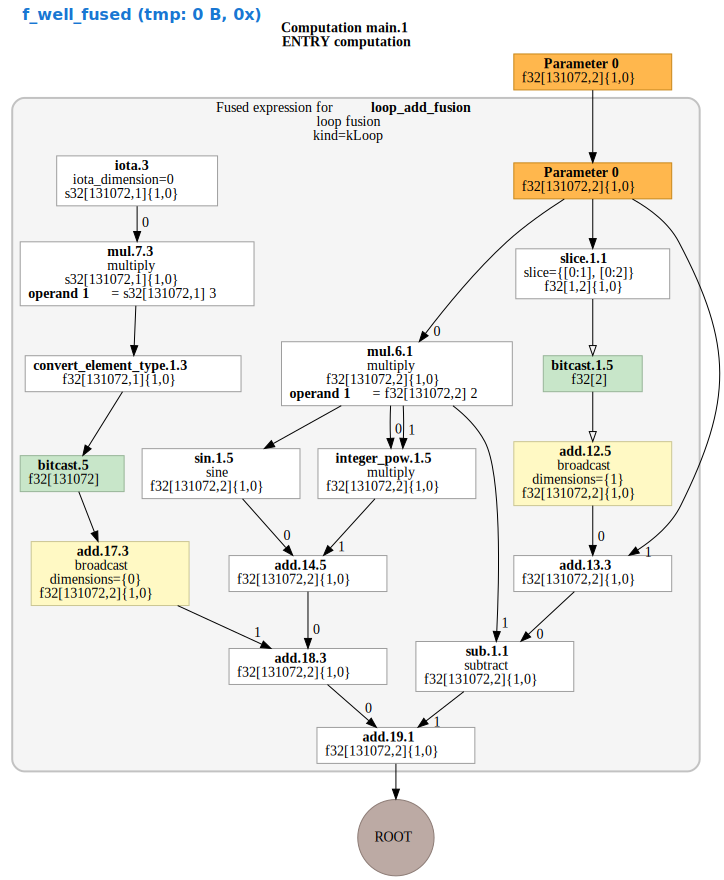

In [3]:
def f_well_fused(x):
    """In general jax does a really good job at fusing (and not creating temporaries)"""
    a = x * 2
    b = jnp.arange(a.shape[0])[:,None] * 3
    c = x[0] + x - a
    return jnp.sin(a) + a**2 + b + c

# Note that all operations are fused into one kernel (i.e. the grey box)
# This program is likely a very-close-to optimal GPU program for this computation
# Generally our goal should be to write code in such a way that jax can fuse as much as possible
show_hlo_info(jax.jit(f_well_fused), x, width=500)

# Fuse barriers
Some operations cannot fuse, creating barriers (e.g. jnp.sum can do that)

--------  Memory usage of f_sum_jax  ---------
code  : 5.1 kB
temp  : 512.0 kB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.5 MB


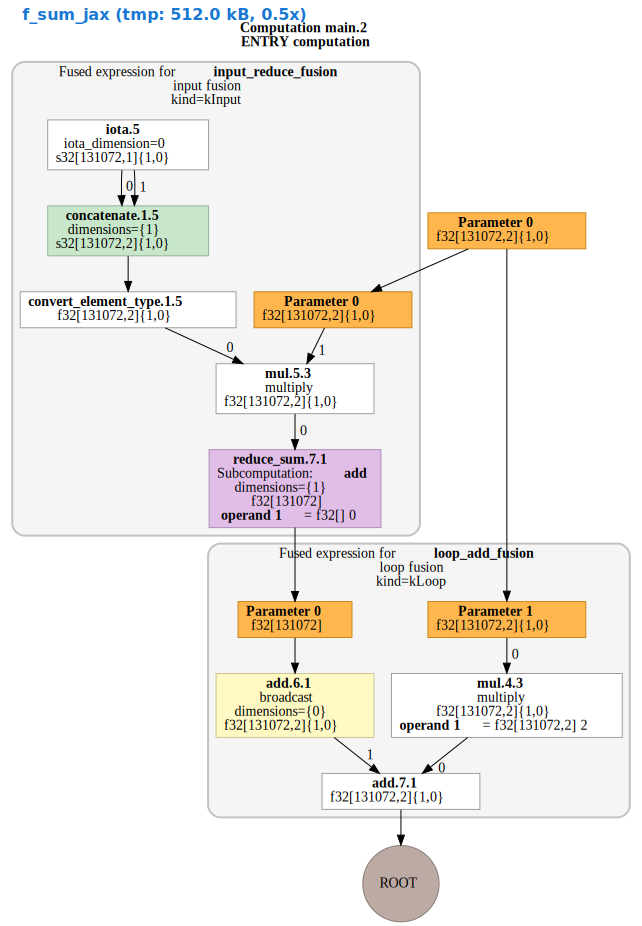

--------  Memory usage of f_sum_explicit  ---------
code  : 3.4 kB
temp  : 0 B
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.0 MB


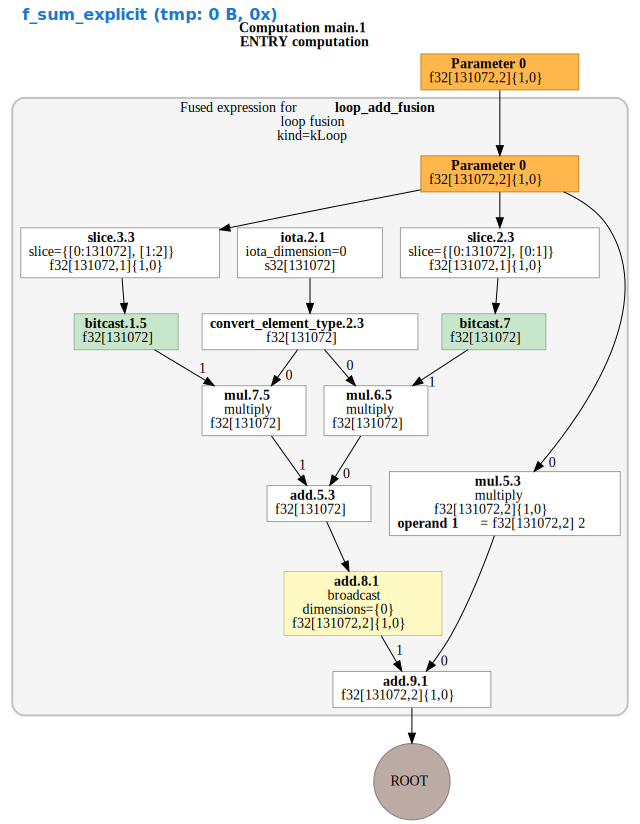

In [4]:
def kvec_mesh(N):
    return jnp.stack((jnp.arange(0, N), jnp.arange(0, N)), axis=-1)

def f_sum_jax(x):
    """Shows: Jax generally does not fuse jnp.sum so don't use it if you can avoid it!
    compare against: f_sum_explicit 
    """
    kvm = kvec_mesh(len(x))
    return x * 2 + jnp.sum(kvm * x, axis=1, keepdims=True)

def f_sum_explicit(x):
    kvm = kvec_mesh(len(x))
    return x * 2 + (kvm[...,0] * x[...,0] + kvm[...,1] * x[...,1])[:,None]

show_hlo_info(jax.jit(f_sum_jax), x)
show_hlo_info(jax.jit(f_sum_explicit), x)

## jitting sub functions
Jitting sub-functions does **not** prevent fusion!

--------  Memory usage of f_with_subjit  ---------
code  : 3.3 kB
temp  : 0 B
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.0 MB


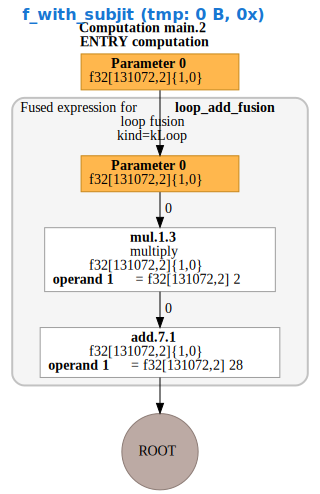

In [5]:
def finternal(x):
    return x * 2 + 25.0
finternal.jit = jax.jit(finternal, inline=False)

def f_with_subjit(x):
    """This fuses fine, allthough we jitted our sub-function"""
    return finternal.jit(x) + 3

show_hlo_info(jax.jit(f_with_subjit), x, width=300)

# Intentional Fusion barrier

--------  Memory usage of f_with_subjit  ---------
code  : 13.1 kB
temp  : 0 B
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.0 MB


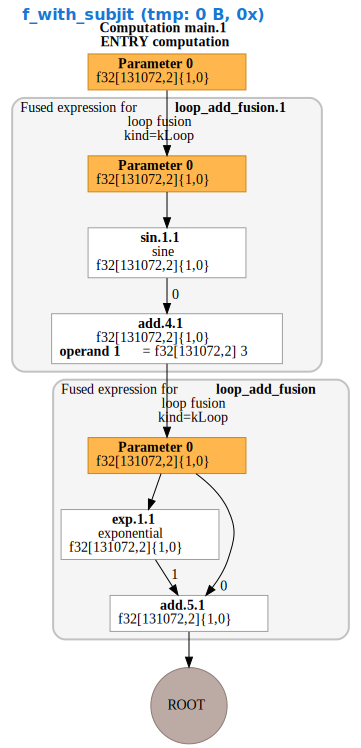

In [6]:
def f_with_subjit(x):
    """Becomes two kernels, because we have a barrier inbetween"""
    S = jax.lax.optimization_barrier(jnp.sin(x) + 3)
    return S + jnp.exp(S)

show_hlo_info(jax.jit(f_with_subjit), x, width=300) 

# FFTs

--------  Memory usage of f_fft3d  ---------
code  : 5.1 kB
temp  : 2.1 MB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 4.1 MB


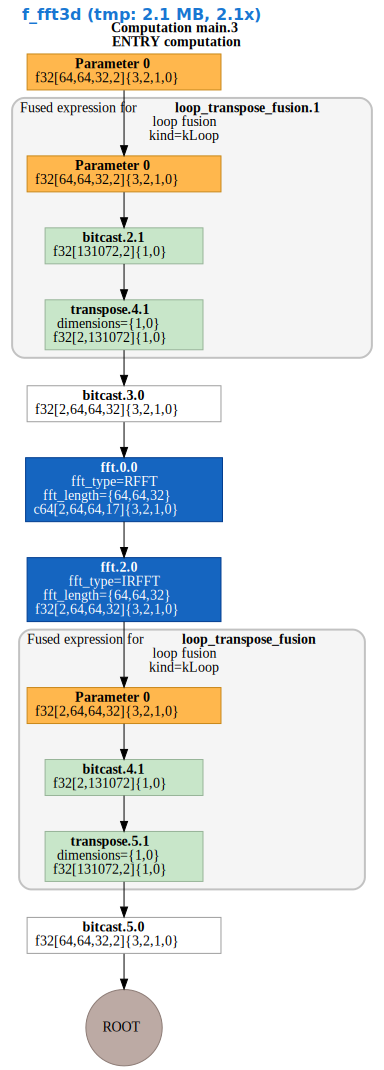

--------  Memory usage of f_fft3d_transposed  ---------
code  : 5.2 kB
temp  : 1.1 MB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 3.1 MB


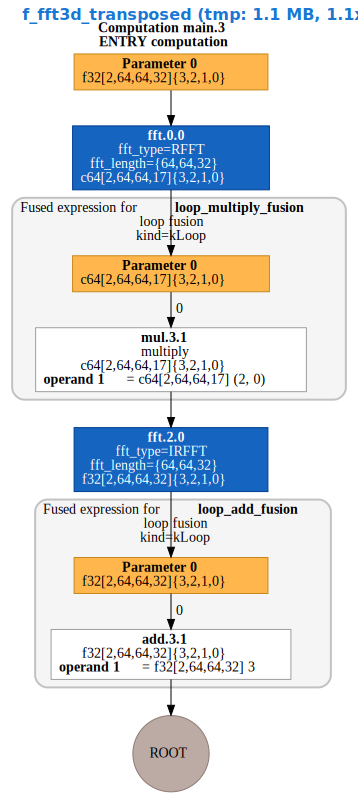

In [7]:
def f_fft3d(x):
    """I was surprised that we need 2x temporaries (rarther than 1x) here!
    This is, because the FFT dimension always has to be the last one, and jax needs to hold the input
    and the output of the Fourier space transpose in memory at the same time.

    compare against: f_fft3d_transposed
    """
    a = jnp.fft.rfftn(x, axes=(0,1,2))
    b = jnp.fft.irfftn(a, axes=(0,1,2))
    return b

def f_fft3d_transposed(x):
    """We can reduce the memory usage by having Input and Output transposed as (2, N,N,N) 
    # instead of (N,N,N,2).
    Note: It seems kernels which are working in place can easily use Input = Output and do
    not need two temporaries, even if Input and Output are temporary. The transposition kernel
    cannot do this however! (I understand why, but I think it is not-optimal in XLA)
    """
    a = jnp.fft.rfftn(x, axes=(1,2,3))
    b = jnp.fft.irfftn(a*2, axes=(1,2,3))
    return b + 3

x3d = jnp.zeros((64,64,32,2)) # Our probe array -- it uses 1MB
show_hlo_info(jax.jit(f_fft3d), x3d, width=250)
show_hlo_info(jax.jit(f_fft3d_transposed), x3d.transpose(3,0,1,2), width=250)

# Loops

--------  Memory usage of f_for  ---------
code  : 6.9 kB
temp  : 513 B
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.0 MB


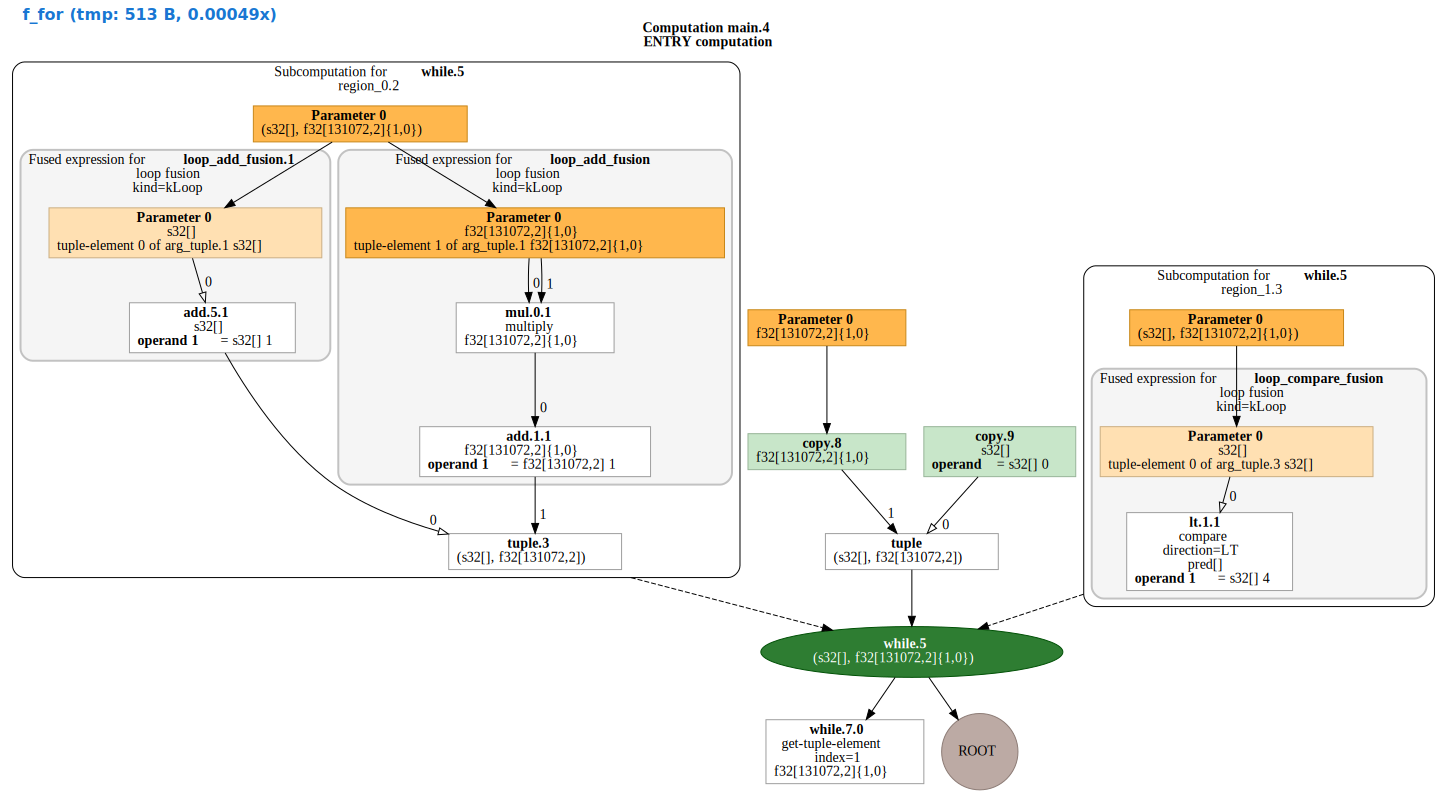

--------  Memory usage of f_for  ---------
code  : 7.2 kB
temp  : 513 B
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.0 MB


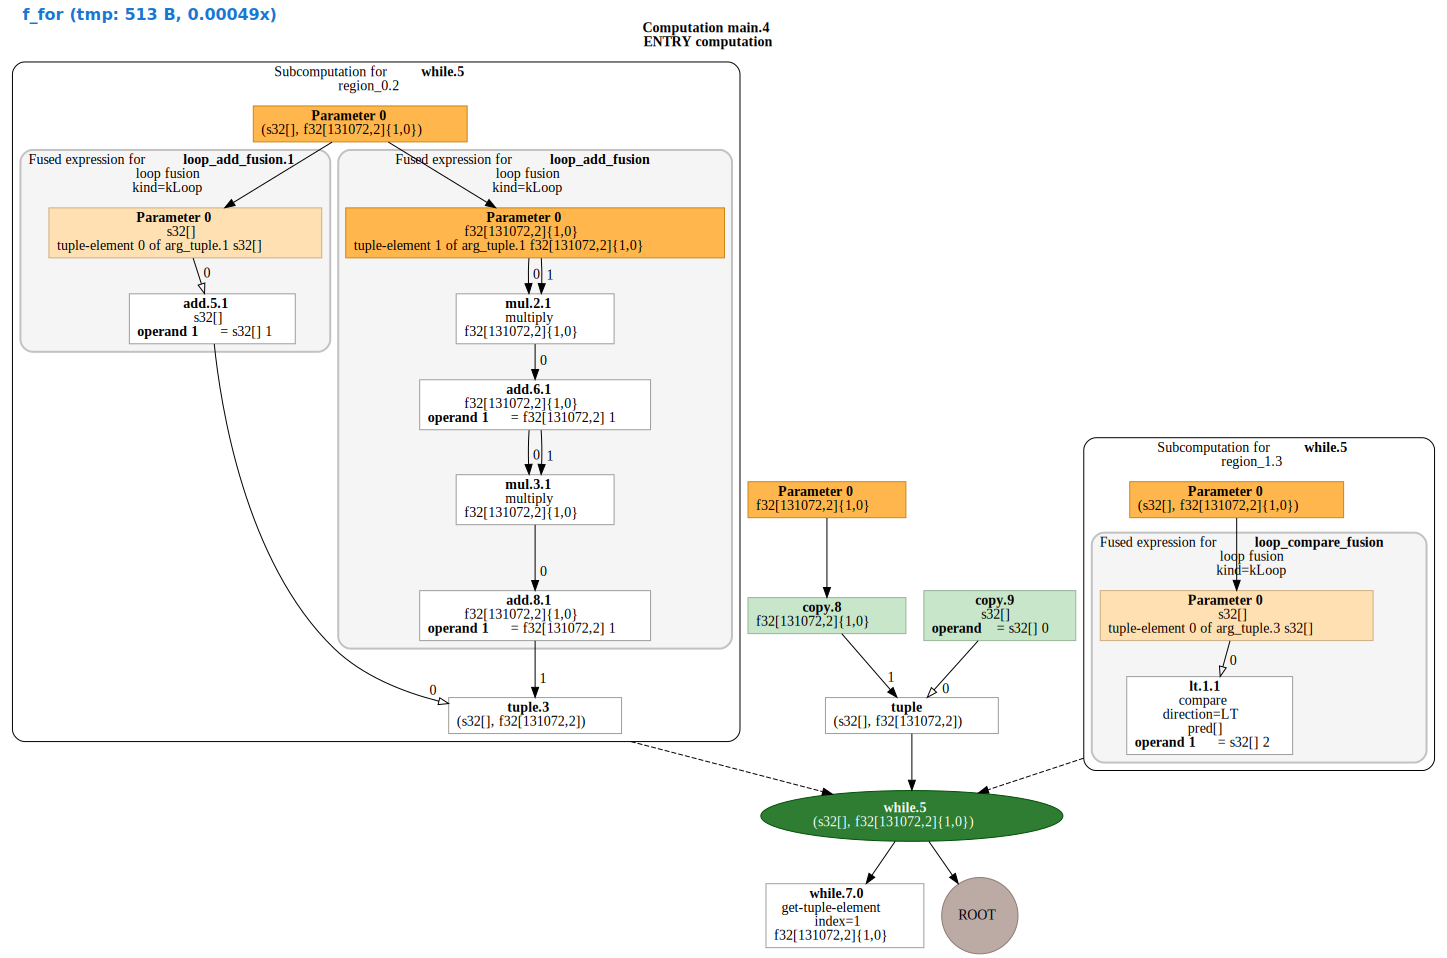

--------  Memory usage of f_for  ---------
code  : 3.7 kB
temp  : 0 B
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.0 MB


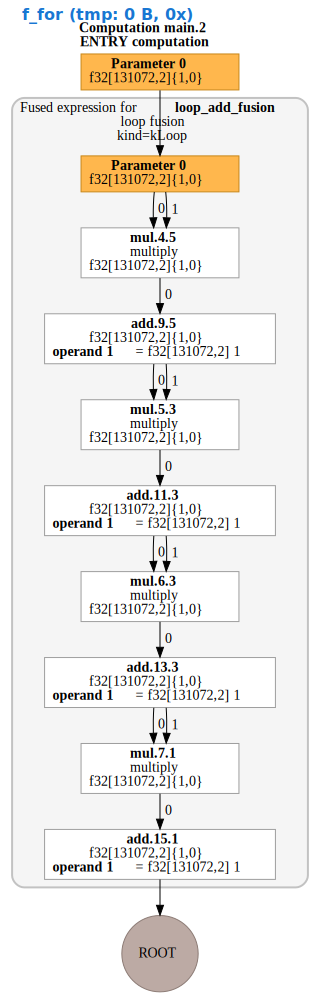

In [8]:
def f_for(x, unroll=None):
    """Loops save their state variables as temporaries -- because each iteration launches a kernel
    If you have a very short loop, consider fully unrolling it.
    """
    def add_x(i, x):
        return x*x + 1
    y = jax.lax.fori_loop(0, 4, add_x, x, unroll=unroll)
    return y

show_hlo_info(jax.jit(f_for, static_argnames="unroll"), x, width=800)
# Partially unrolled, saves half of the kernel launches and I/O, but still needs a temporary
show_hlo_info(jax.jit(f_for, static_argnames="unroll"), x, unroll=2, width=800)
# Fully unrolled, becomes a single kernel avoids 1 temporary:
# (Not sure whether this is any different than a pure python loop)
show_hlo_info(jax.jit(f_for, static_argnames="unroll"), x, unroll=4, width=200)

# Intermediates

--------  Memory usage of f_recalc  ---------
code  : 12.5 kB
temp  : 512.0 kB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.5 MB


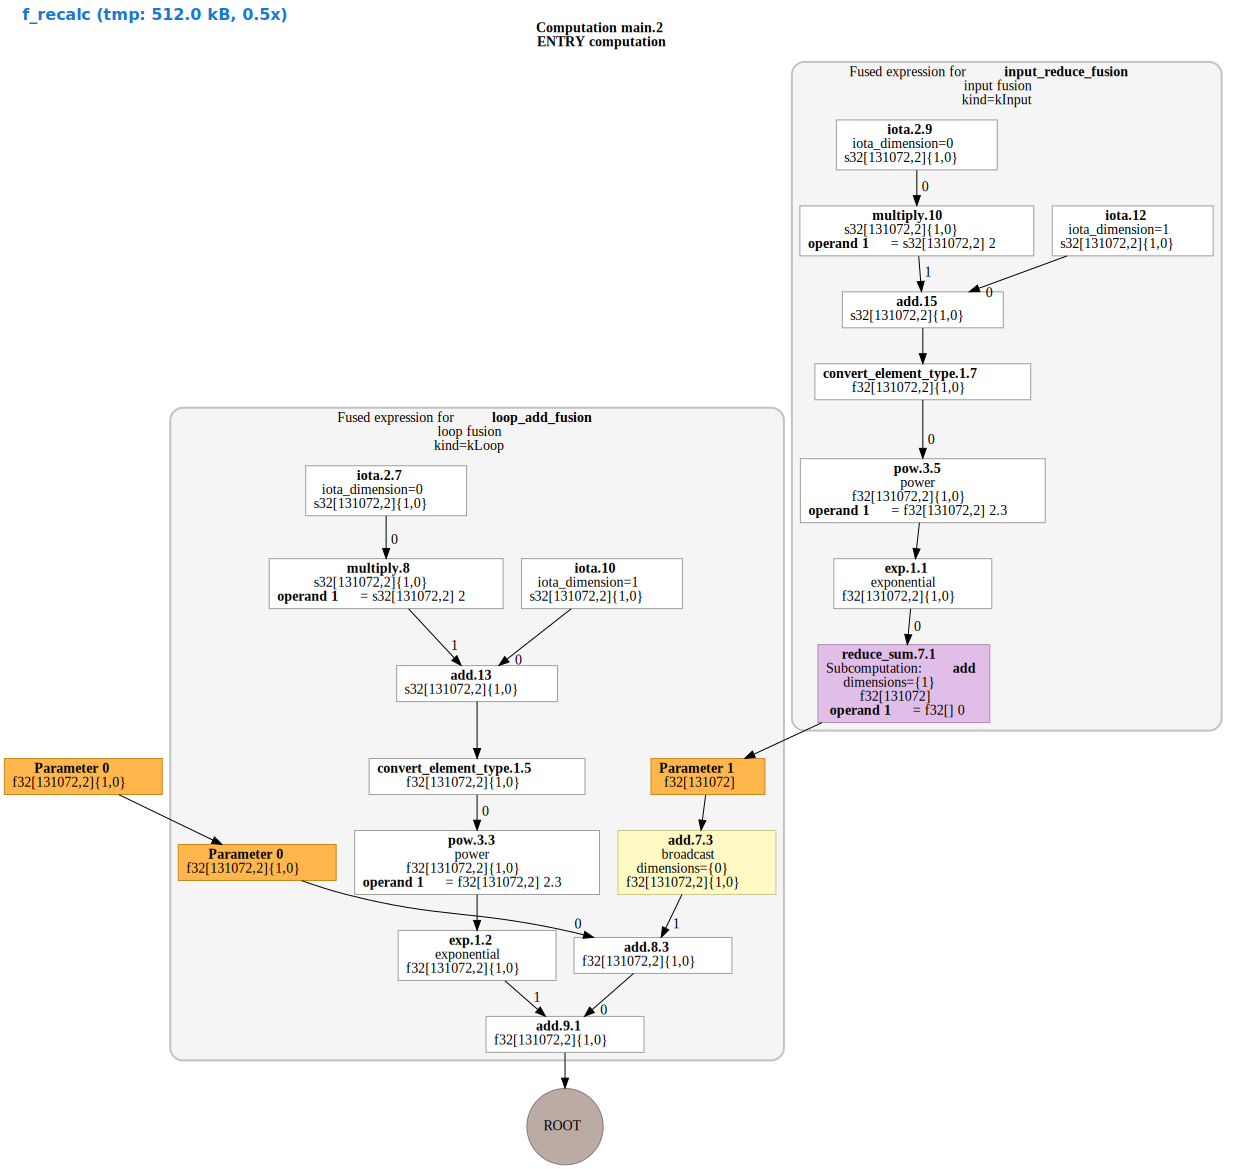

--------  Memory usage of f_stored  ---------
code  : 18.6 kB
temp  : 512.0 kB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.5 MB


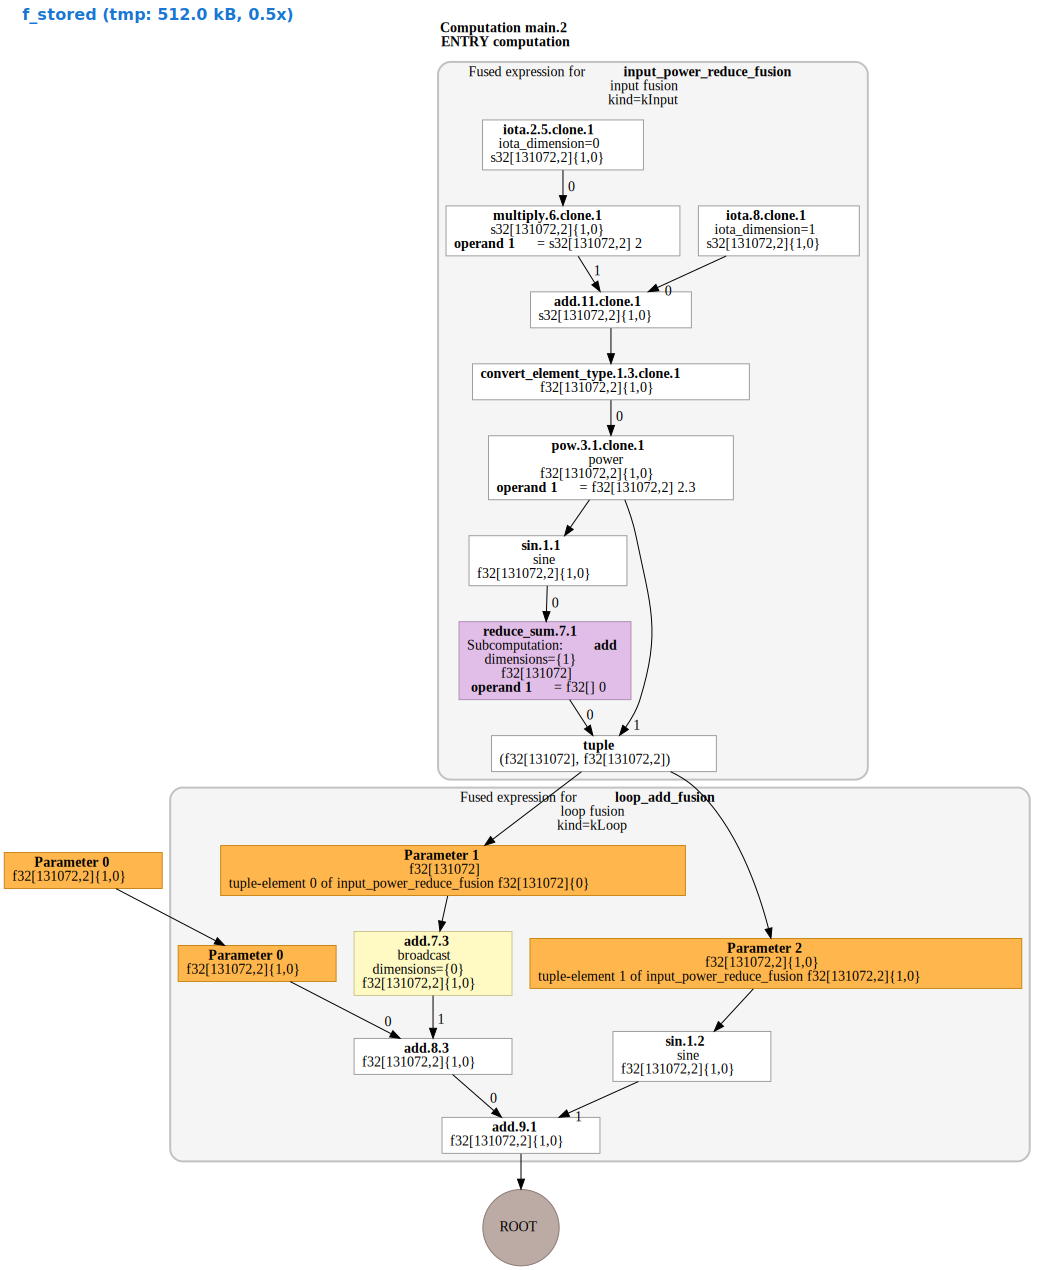

In [9]:
def f_recalc(x):
    """Here jax smartly recalculateds an intermediate rather than storing it.

    Jax sometimes recalculates intermediates and sometimes stores them. It is very unpredictable.
    """
    im = jnp.exp(jnp.arange(x.size).reshape(x.shape) ** 2.3)

    # Here we use a sum to create a fusion barrier
    # Imagine this represents a long calculation that cannot be fused
    a = x + jnp.sum(im, axis=-1, keepdims=True) 

    # Later we use "im" again. Jax recalculates it rather than storing it, great!
    return a + im 

def f_stored(x):
    """(Note the two outputs passed and the recalculation part of the second graph missing)"""
    im = jnp.sin(jnp.arange(x.size).reshape(x.shape) ** 2.3) # Tiny difference, but changes graph a lot!
    a = x + jnp.sum(im, axis=-1, keepdims=True) 

    return a + im

show_hlo_info(jax.jit(f_recalc), x, width=700)
show_hlo_info(jax.jit(f_stored), x, width=700)

# Common sub-expression elimination

--------  Memory usage of f_cse  ---------
code  : 37.8 kB
temp  : 514.3 kB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.5 MB


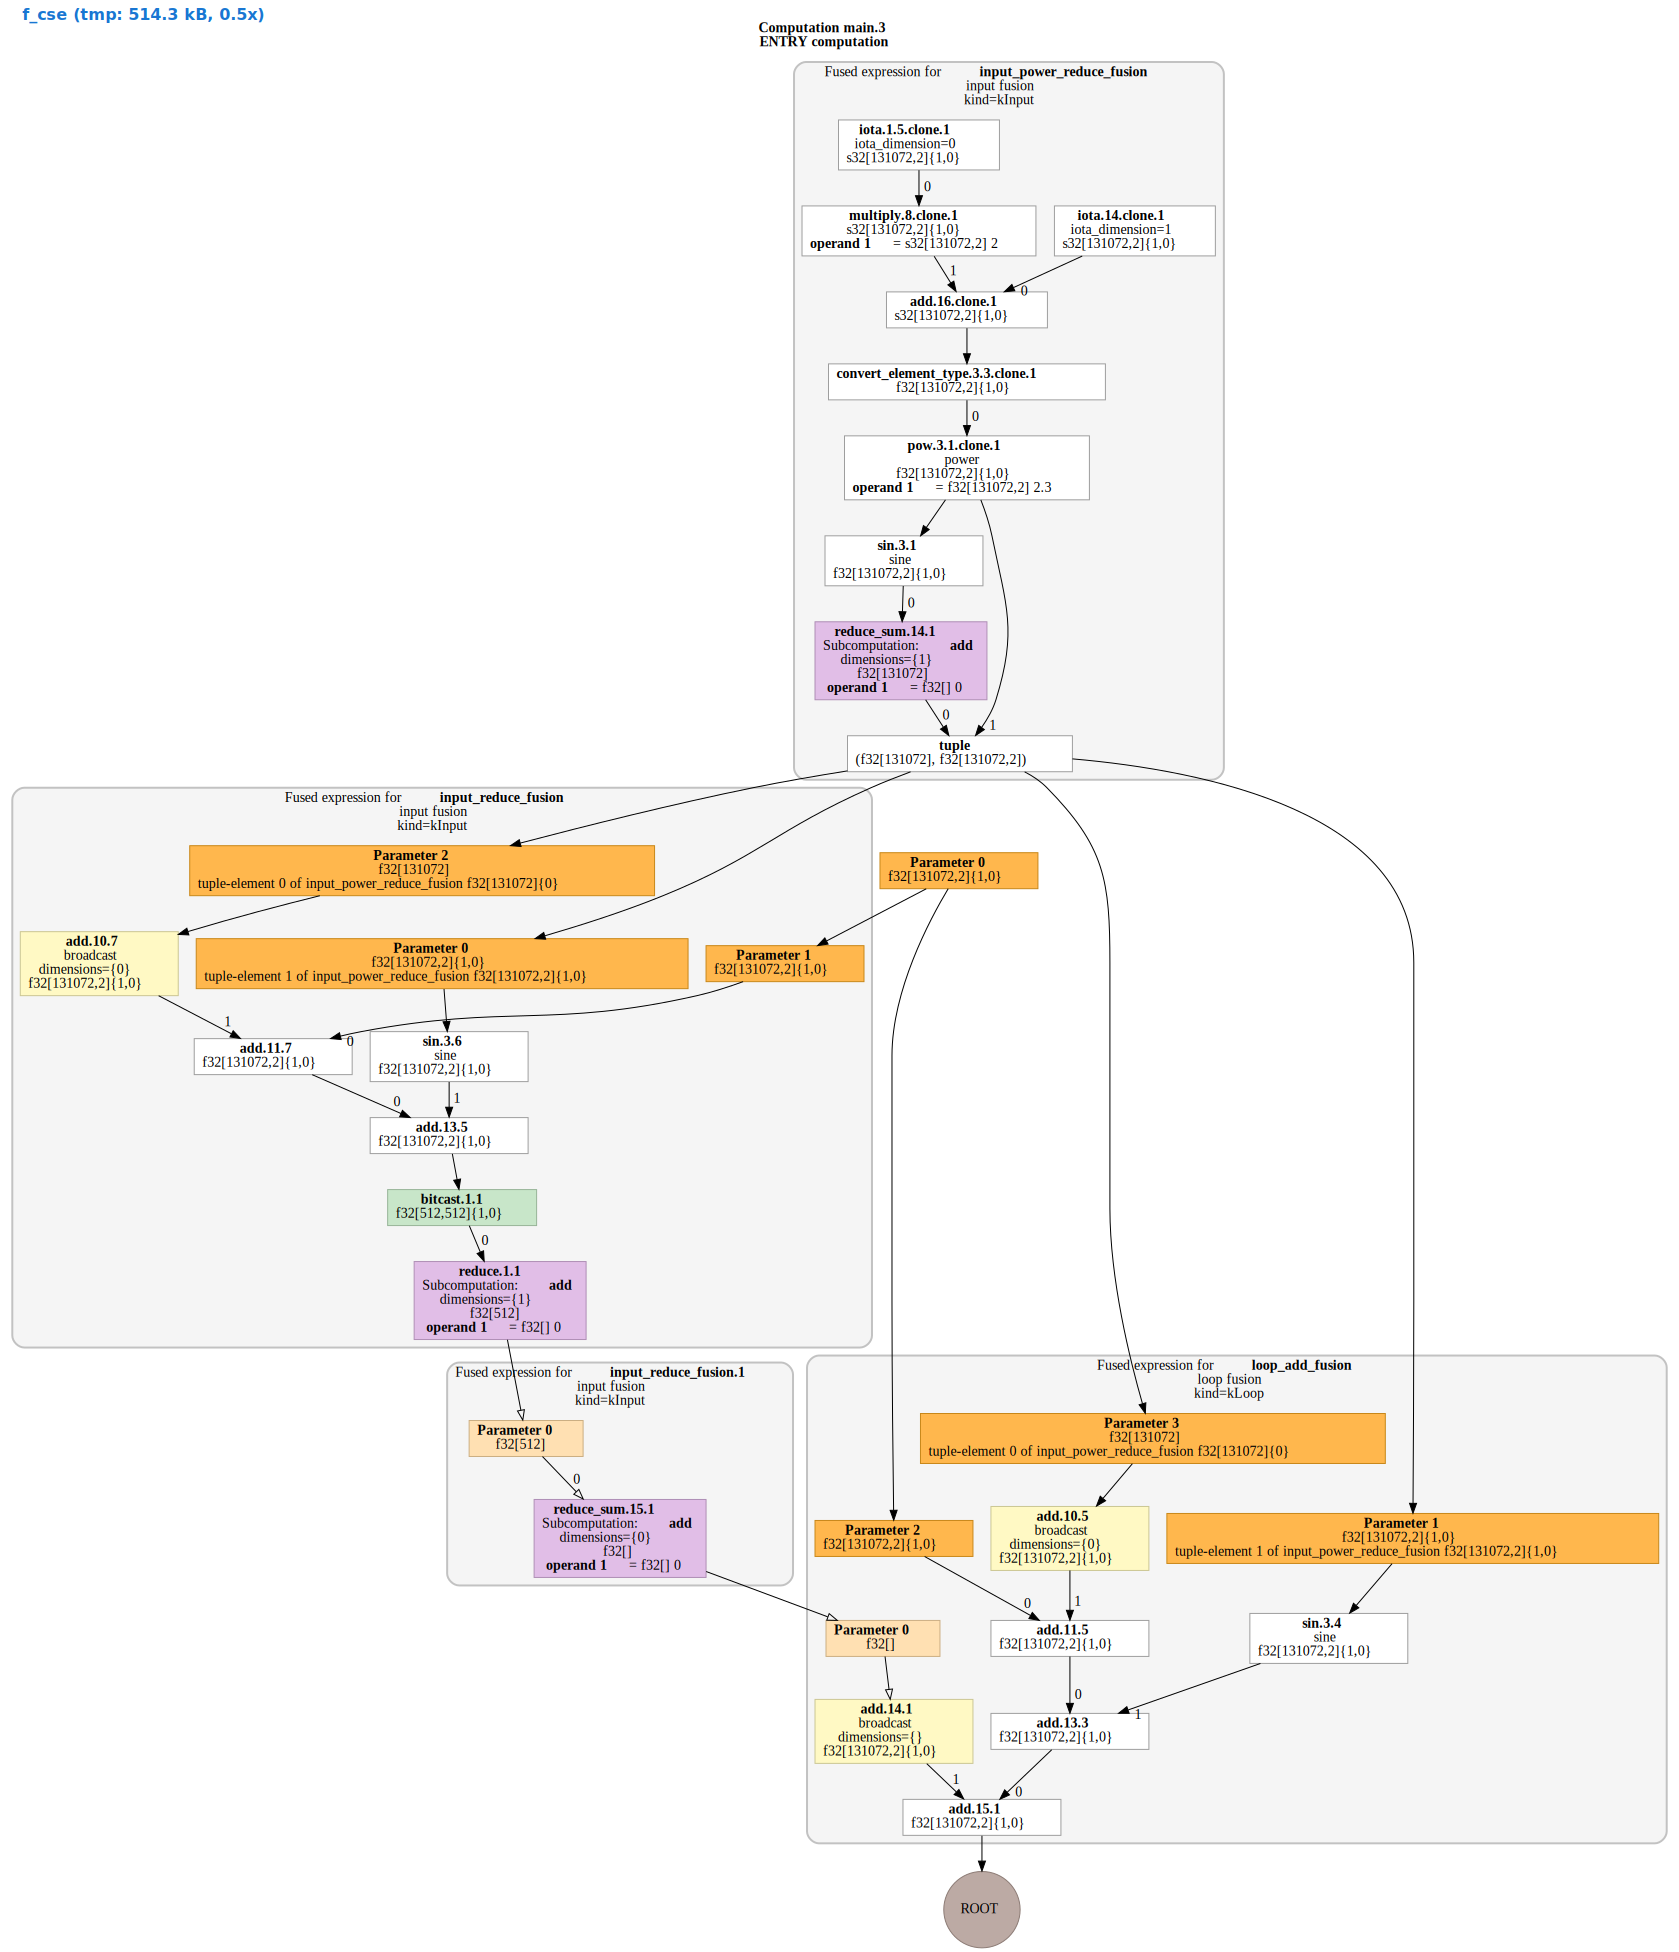

--------  Memory usage of f_cse_loop_expl  ---------
code  : 20.5 kB
temp  : 1.0 MB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 3.0 MB


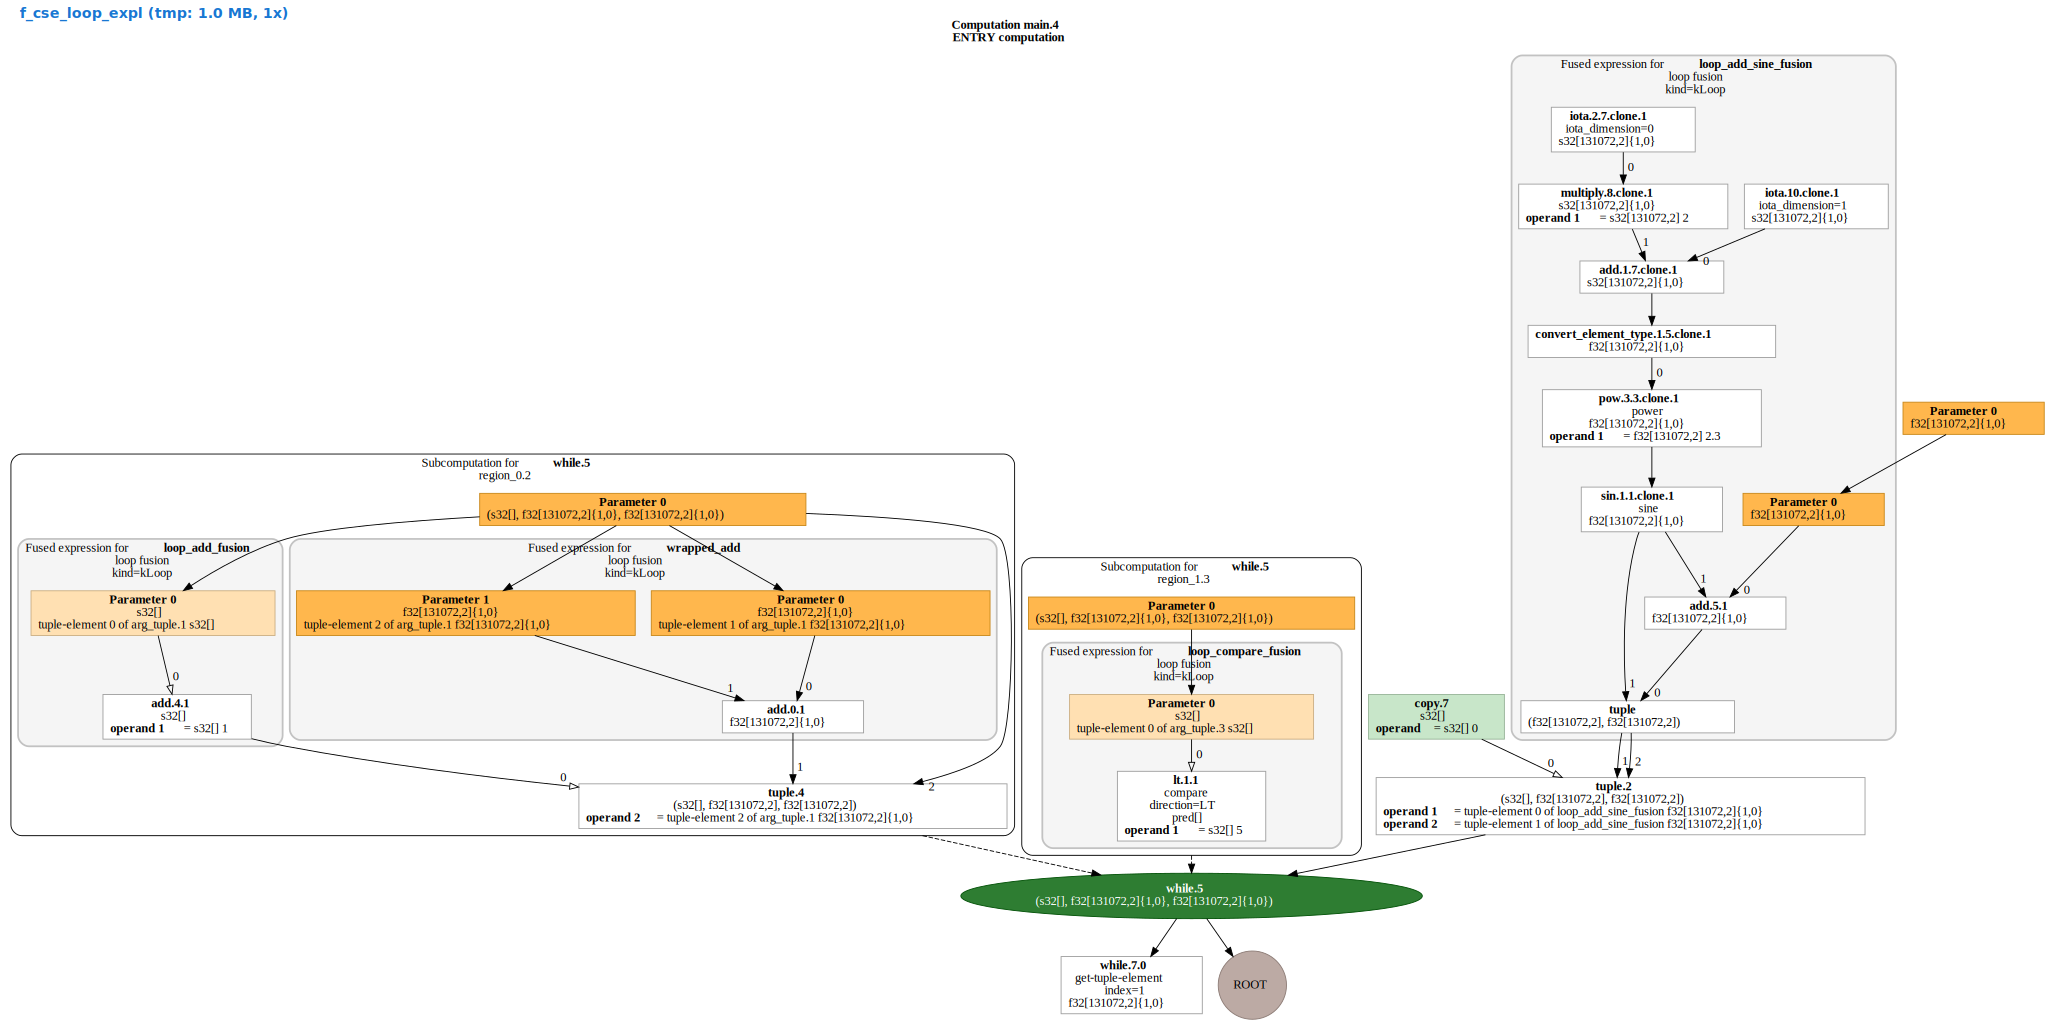

--------  Memory usage of f_cse_loop_impl  ---------
code  : 31.8 kB
temp  : 513 B
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 2.0 MB


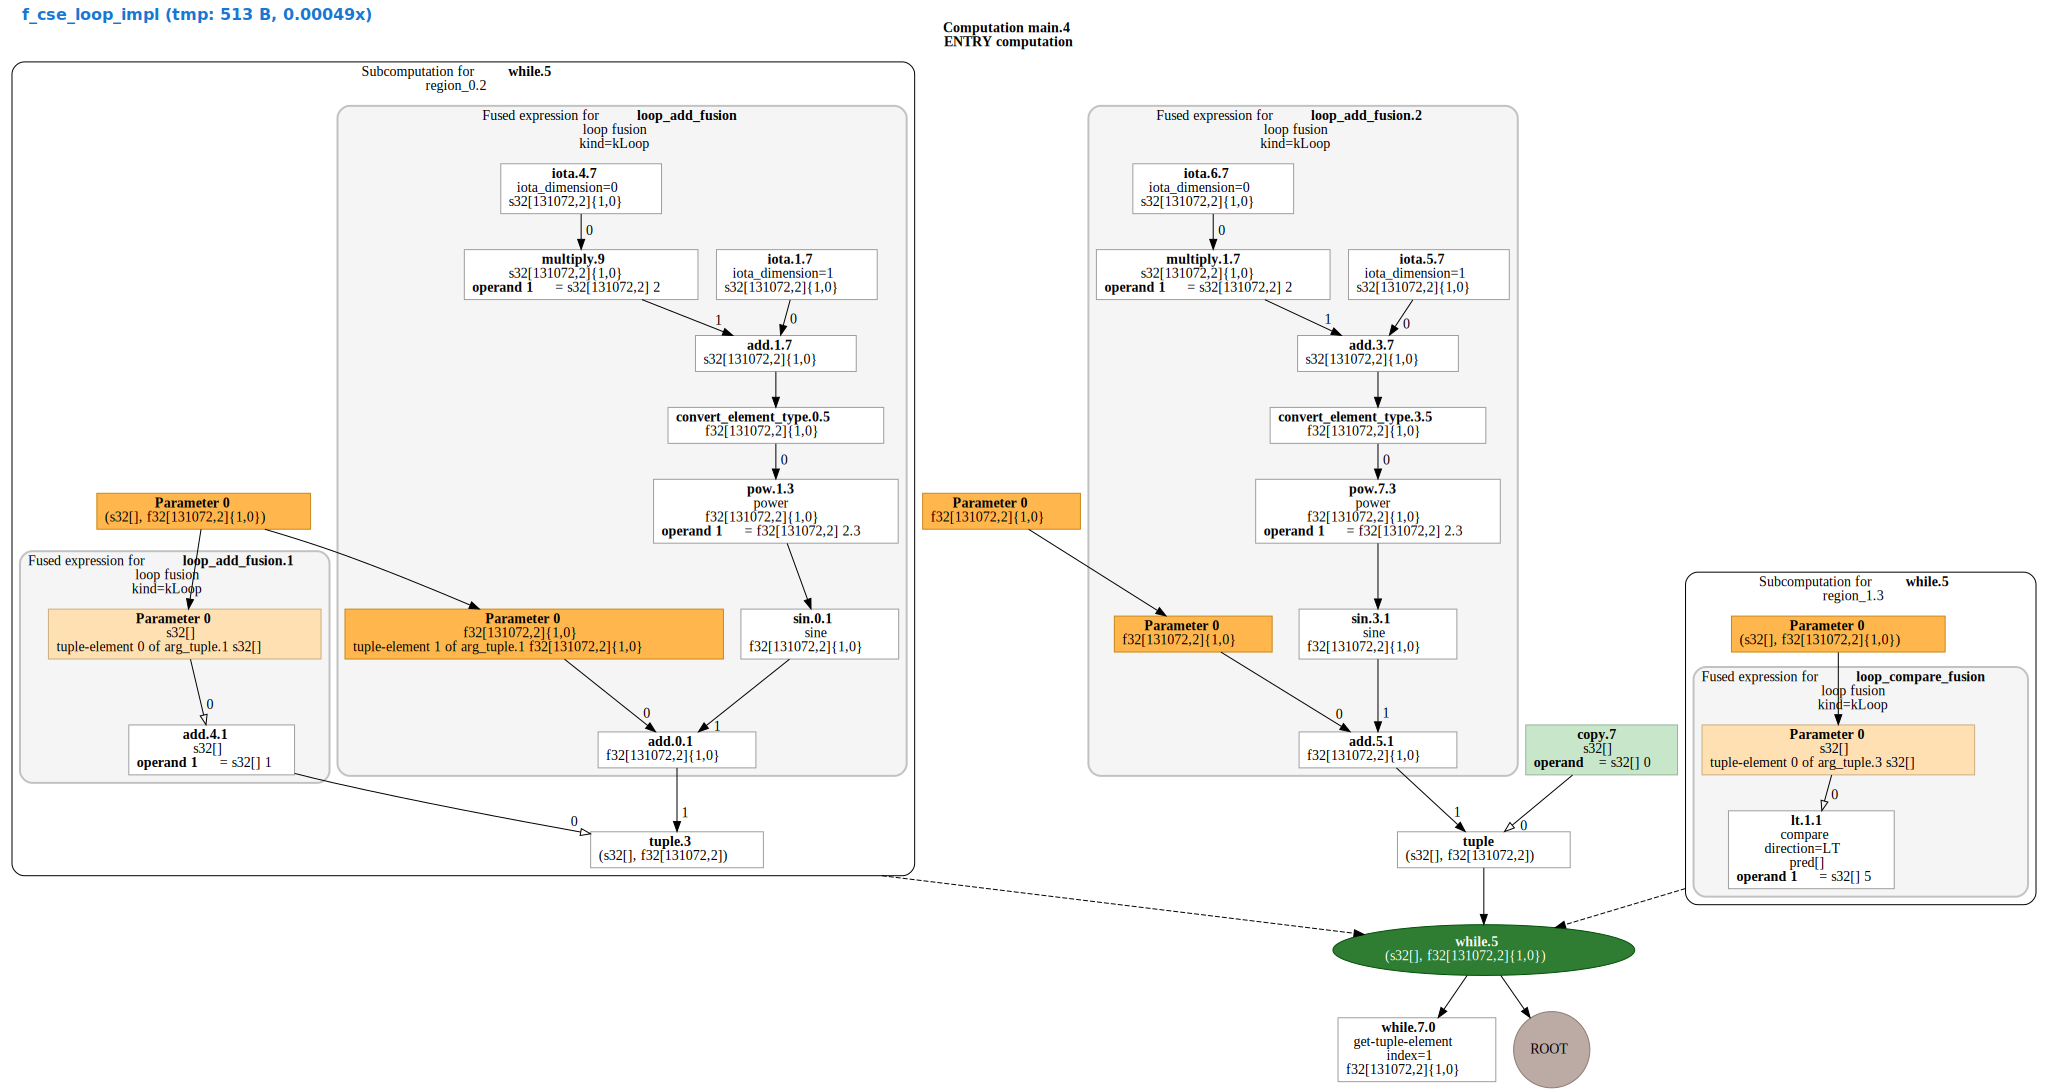

--------  Memory usage of f_cse_loop_after  ---------
code  : 40.5 kB
temp  : 1.0 MB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 3.0 MB


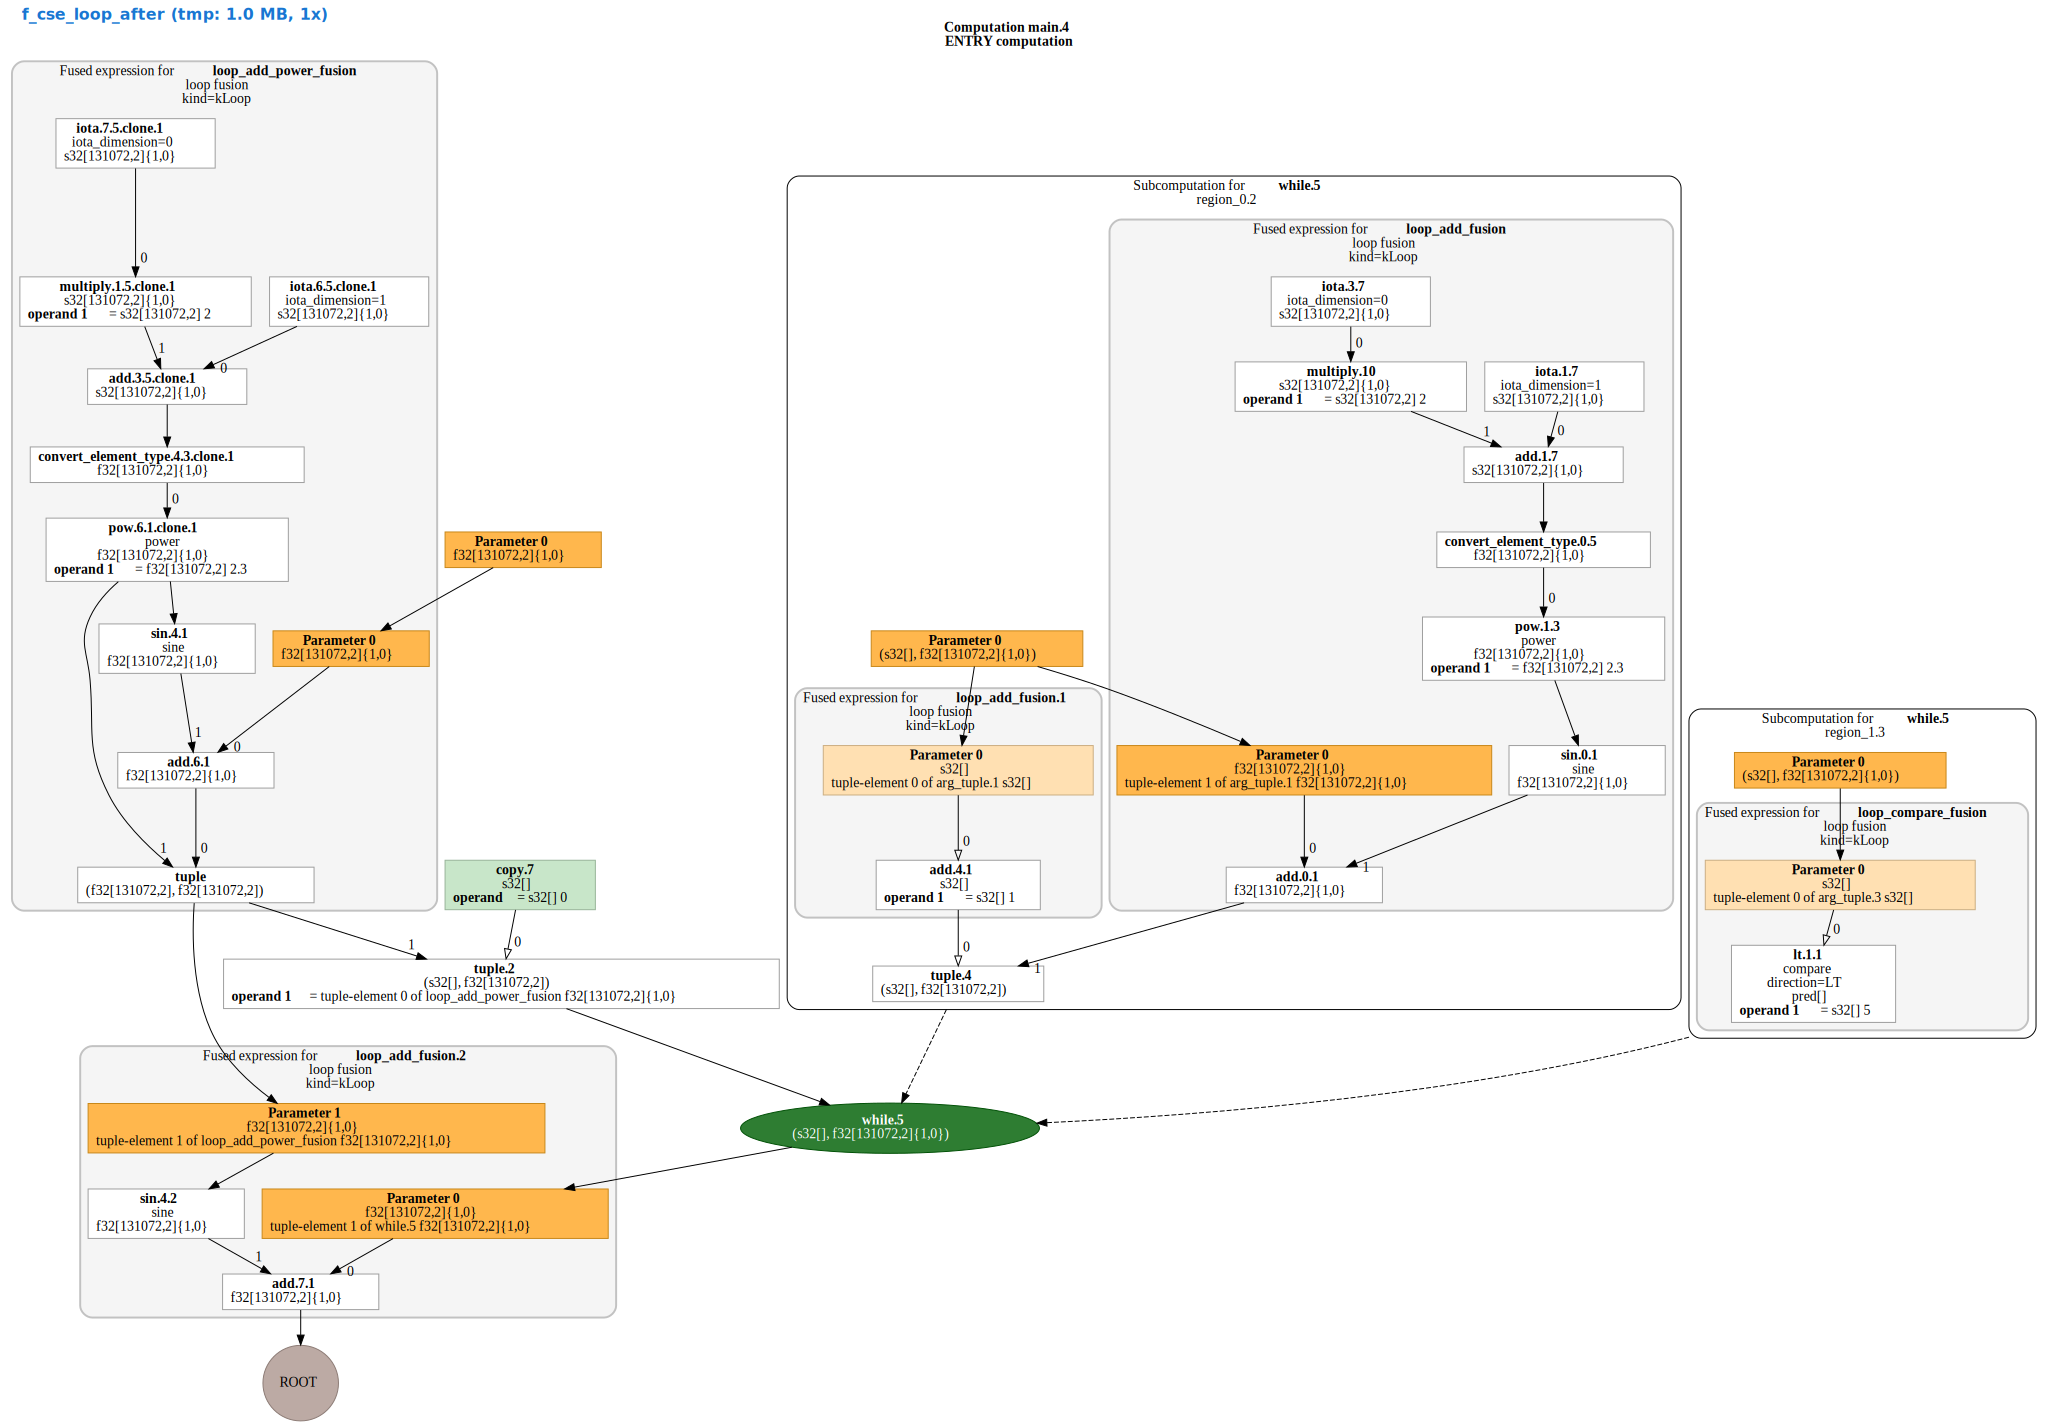

In [10]:
def get_im(x, eps=0.):
    return jnp.sin((jnp.arange(x.size).reshape(x.shape) + eps) ** 2.3)

def f_cse(x):
    """Here jax finds the common sub-expression and calculates it once"""
    a = x + jnp.sum(get_im(x), axis=-1, keepdims=True) 

    b =  jnp.sum(a + get_im(x))

    return a + get_im(x) + b

def f_cse_loop_expl(x):
    """Here it does, too, because we told it explicitly"""
    im = get_im(x)

    def step(i, a):
        return a + im

    return jax.lax.fori_loop(0, 5, step, x + im)

def f_cse_loop_impl(x):
    """Here it does not find the common sub-expression, it will be recalculated
    Likely loops live in a different scope and CSE does not identify sub-expressions across scopes
    (this is actually what we want! Uses less memory)"""
    def step(i, a):
        return a + get_im(x)

    return jax.lax.fori_loop(0, 5, step, x + get_im(x))

def f_cse_loop_after(x):
    """Finds a common sub-expression between pre-and post-loop... increase memory again..."""
    def step(i, a):
        return a + get_im(x)

    return jax.lax.fori_loop(0, 5, step, x + get_im(x)) + get_im(x) # if we put eps = 1e-10 here, it will not find it

show_hlo_info(jax.jit(f_cse), x, width=800)
show_hlo_info(jax.jit(f_cse_loop_expl), x, width=1000)
show_hlo_info(jax.jit(f_cse_loop_impl), x, width=1000)
show_hlo_info(jax.jit(f_cse_loop_after), x, width=1000)

# How to optimally recalculate a Fourier k-mesh

--------  Memory usage of get_kmesh_naive  ---------
code  : 6.7 kB
temp  : 256 B
arg   : 0 B
output: 528.0 kB
alias : 0 B
peak  : 528.2 kB


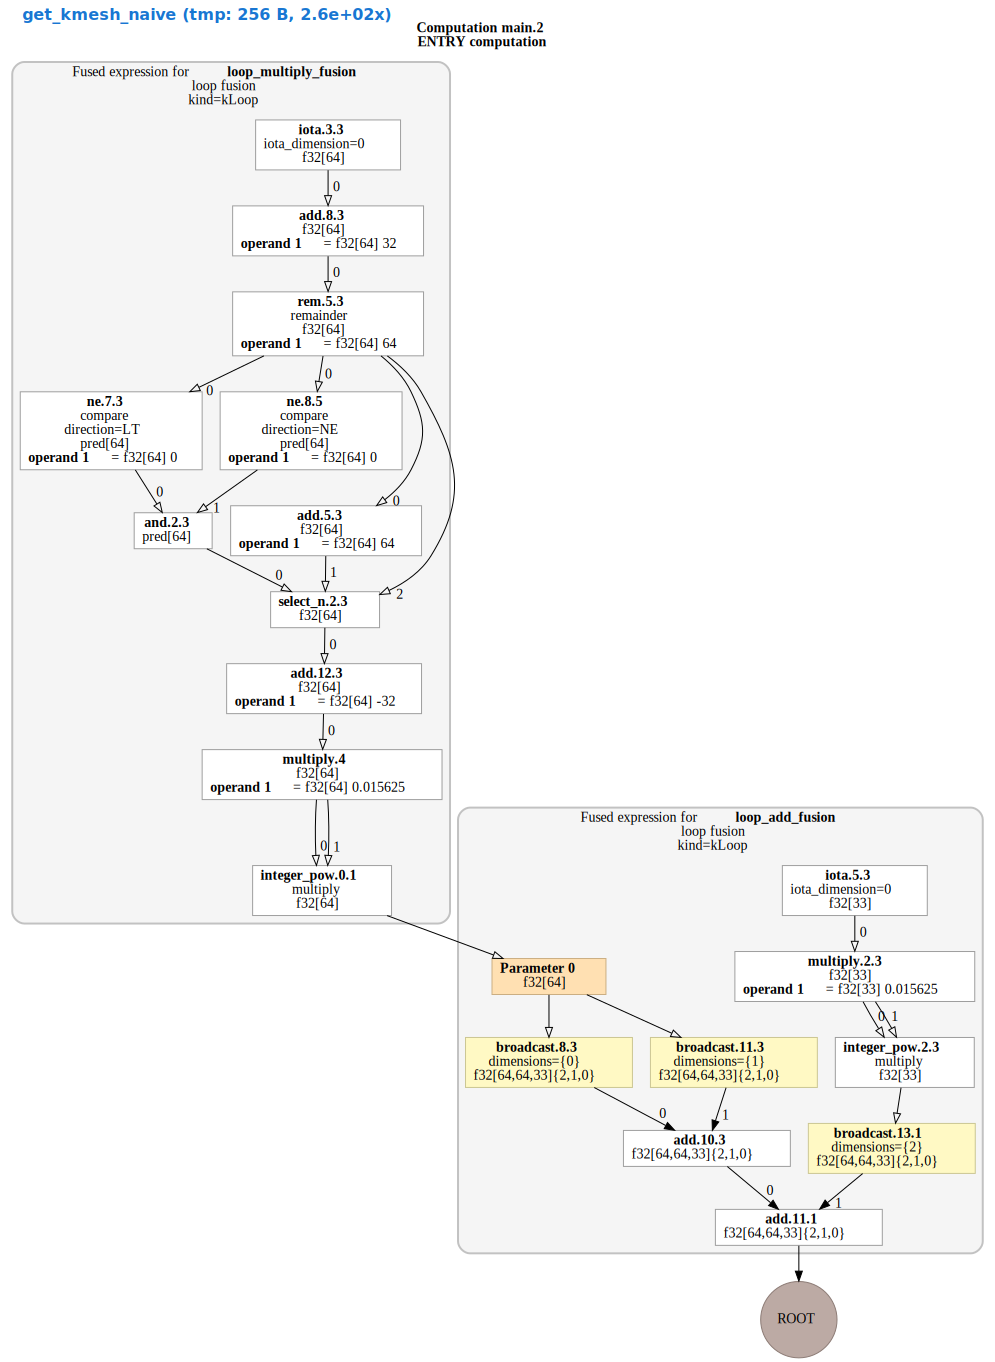

--------  Memory usage of get_kmesh  ---------
code  : 4.5 kB
temp  : 0 B
arg   : 0 B
output: 528.0 kB
alias : 0 B
peak  : 528.0 kB


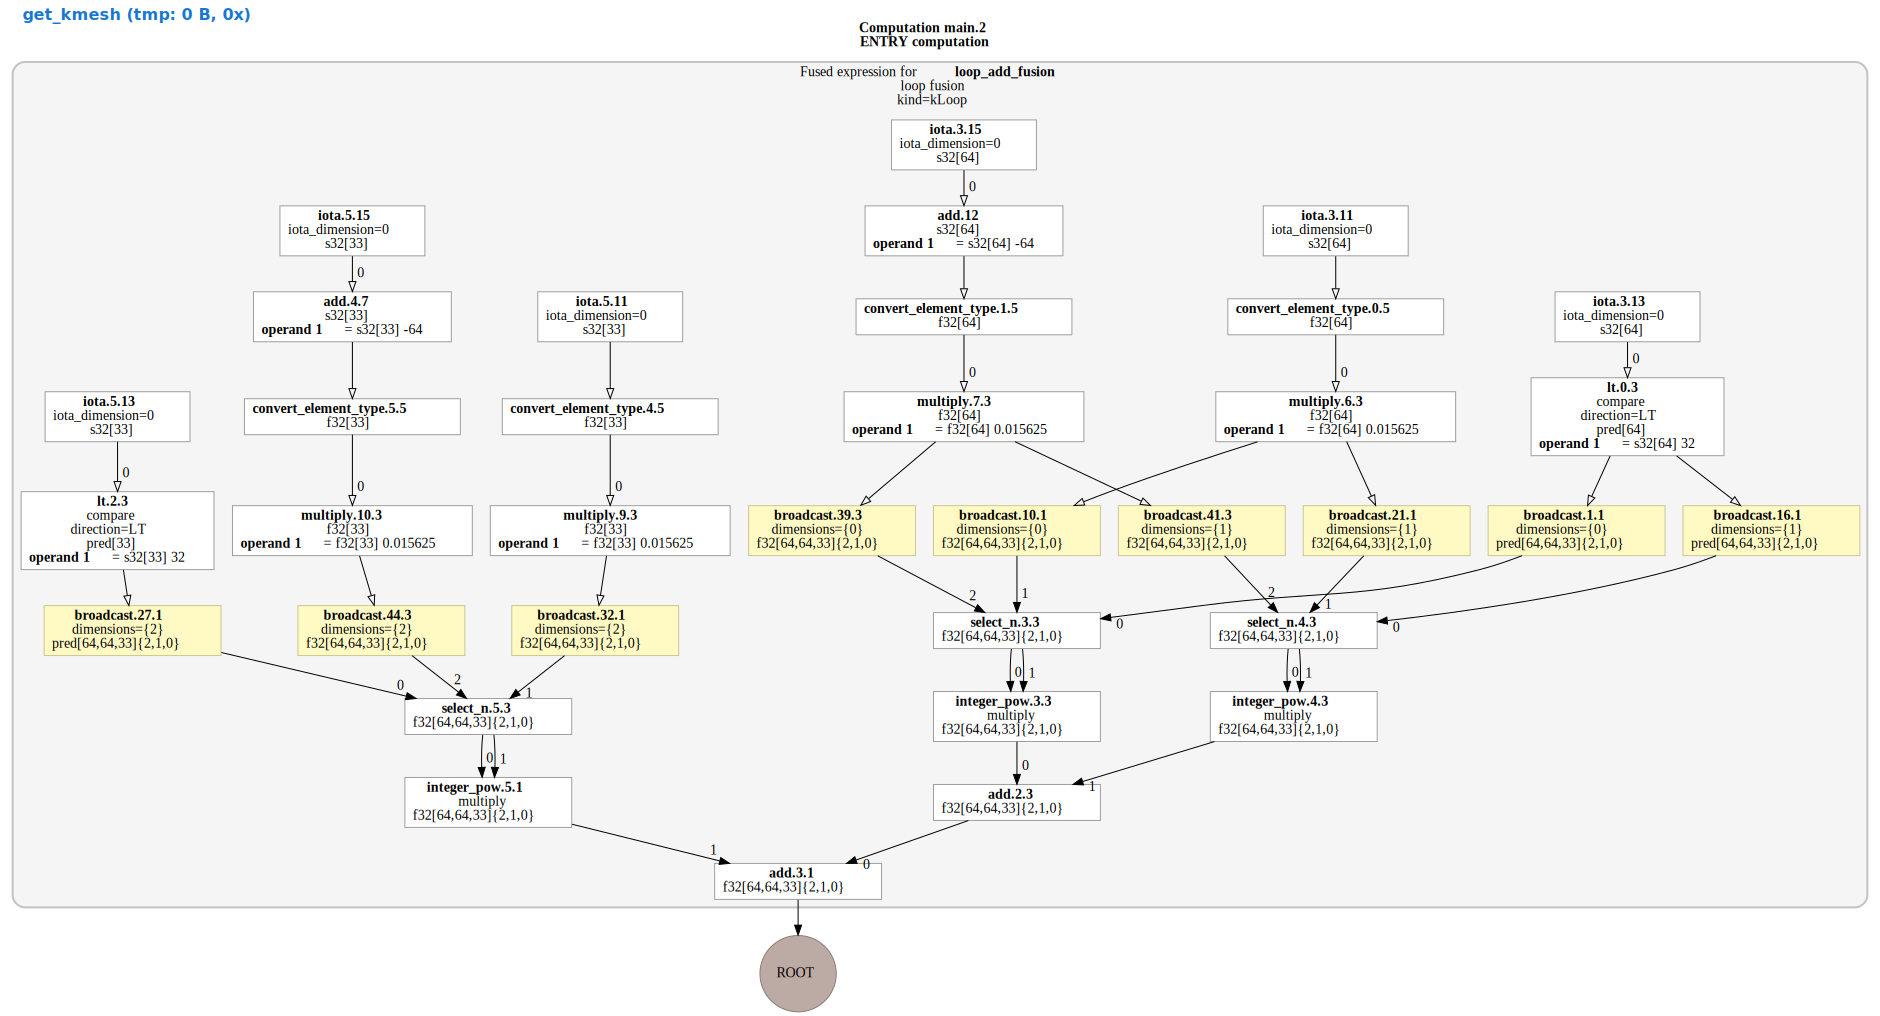

In [11]:
def get_kmesh_naive(rho, d=1., norm2=False, real=True):
    """In general d=boxsize/(2*np.pi*rho.shape[0])
    Here with norm2=True, we tend to get two kernels"""
    kx = jnp.fft.fftfreq(rho.shape[0], d=d)
    ky = jnp.fft.fftfreq(rho.shape[1], d=d)
    if real:
        kz = jnp.fft.rfftfreq(rho.shape[2], d=d)
    else:
        kz = jnp.fft.fftfreq(rho.shape[2], d=d)

    kx,ky,kz = jnp.meshgrid(kx, ky, kz, indexing="ij")
    if norm2:
        return kx**2 + ky**2 + kz**2
    else:
        return jnp.stack((kx,ky,kz), axis=-1)

def myfftfreq(i, n, d=1.0):
    """Does the same as jnp.fft.fftfreq(n, d)[i] but avoids creating the frequency array"""
    return jnp.where(i < (n+1)//2, i / n, (i - n)/n) / d
def myrfftfreq(i, n, d=1.0):
    """Does the same as jnp.fft.rfftfreq(n, d)[i] but avoids creating the frequency array"""
    return i / n / d

for n in [3, 8, 16, 17, 32, 64, 128]: # Test that our fftfreq implementation is correct
    assert(jnp.all(jnp.fft.fftfreq(n) == myfftfreq(jnp.arange(n), n)))
    assert(jnp.all(jnp.fft.rfftfreq(n) == myrfftfreq(jnp.arange((n//2)+1), n)))

def get_kmesh(rho, d=1., norm2=False, real=True):
    """By starting with `jnp.indices` we are more likely to gurantee to achieve a single kernel,
    that can easily be fused later on, since the kernel dispatch dimensions will likely be 
    identical with the needed output dimensions
    """
    ix,iy,iz = jnp.indices((rho.shape[0], rho.shape[1], (rho.shape[2]//2)+1 if real else rho.shape[2]))
    
    kx = myfftfreq(ix, rho.shape[0], d=d)
    ky = myfftfreq(iy, rho.shape[1], d=d)
    kz = myfftfreq(iz, rho.shape[2], d=d)
    
    if norm2:
        return kx**2 + ky**2 + kz**2
    else:
        return jnp.stack((kx,ky,kz), axis=-1)

show_hlo_info(jax.jit(get_kmesh_naive, static_argnames=("norm2", "real")), jnp.zeros((64,64,64)), norm2=True, width=600)
show_hlo_info(jax.jit(get_kmesh, static_argnames=("norm2", "real")), jnp.zeros((64,64,64)), norm2=True, width=800)

for n in [3, 8, 16, 17, 32, 64, 128]: 
    xin = jnp.zeros((n,n,n))
    km1 = get_kmesh_naive(xin, norm2=True)
    km2 = get_kmesh(xin, norm2=True)
    assert(jnp.allclose(km1, km2))

--------  Memory usage of f_filter_with_temp  ---------
code  : 10.8 kB
temp  : 1.5 MB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 3.5 MB


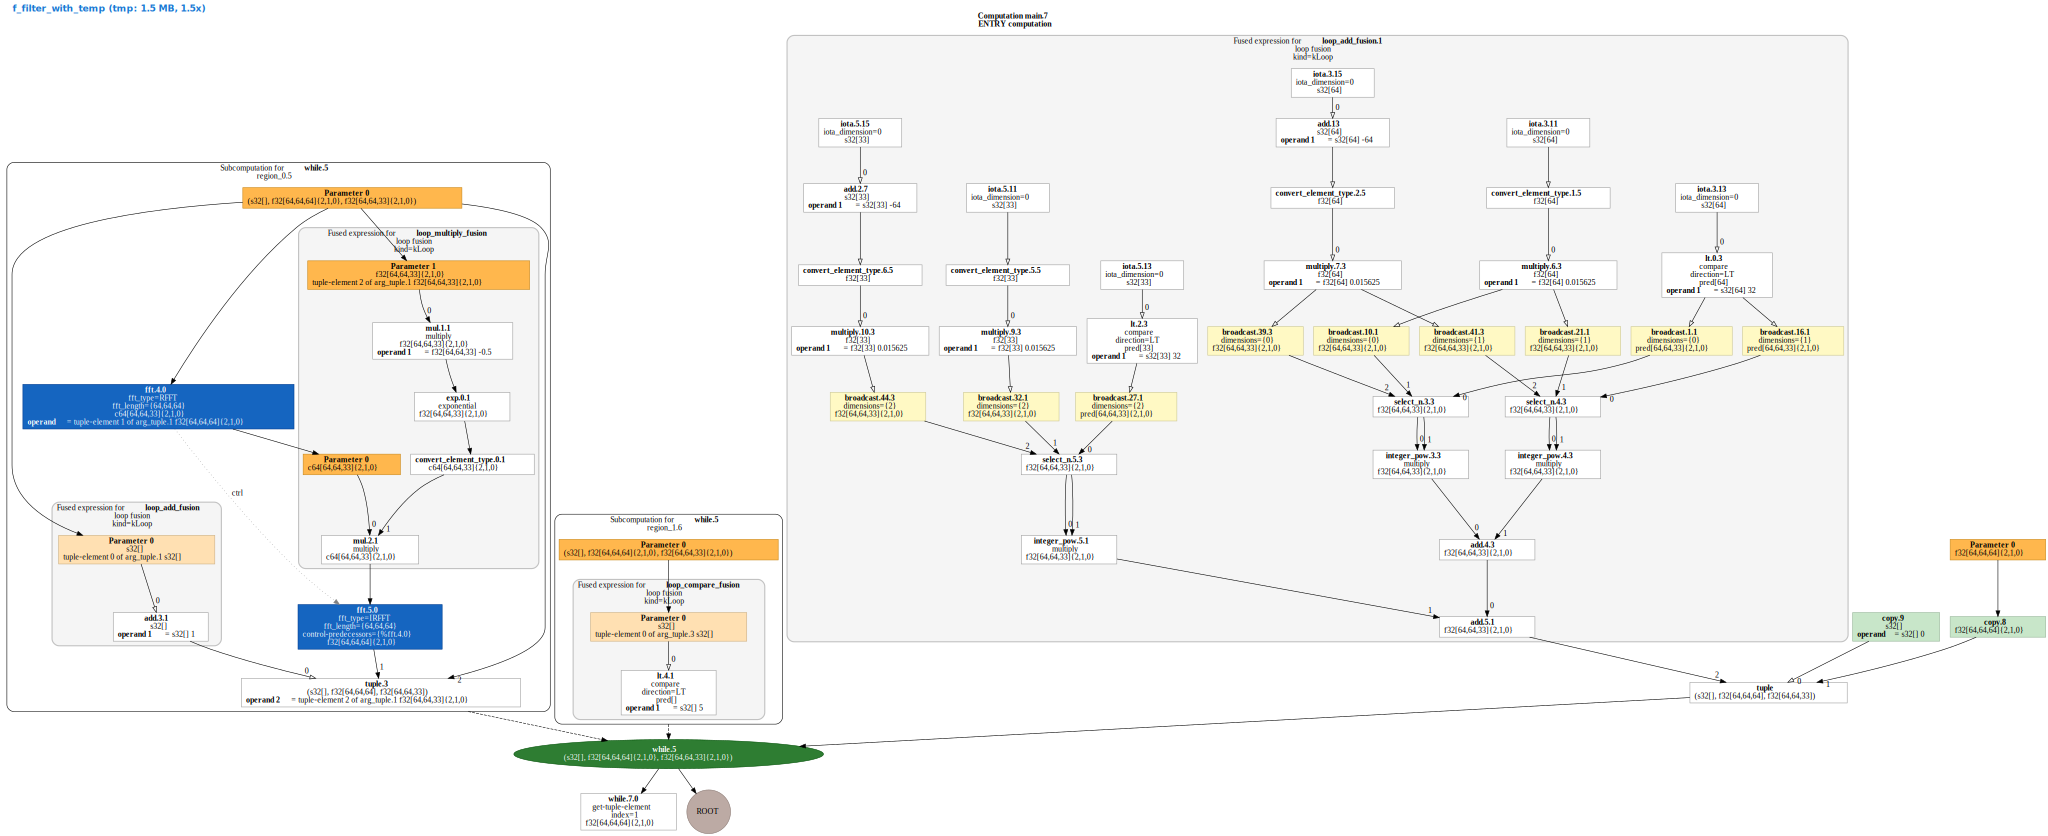

--------  Memory usage of f_filter_with_recalc  ---------
code  : 9.2 kB
temp  : 1.0 MB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 3.0 MB


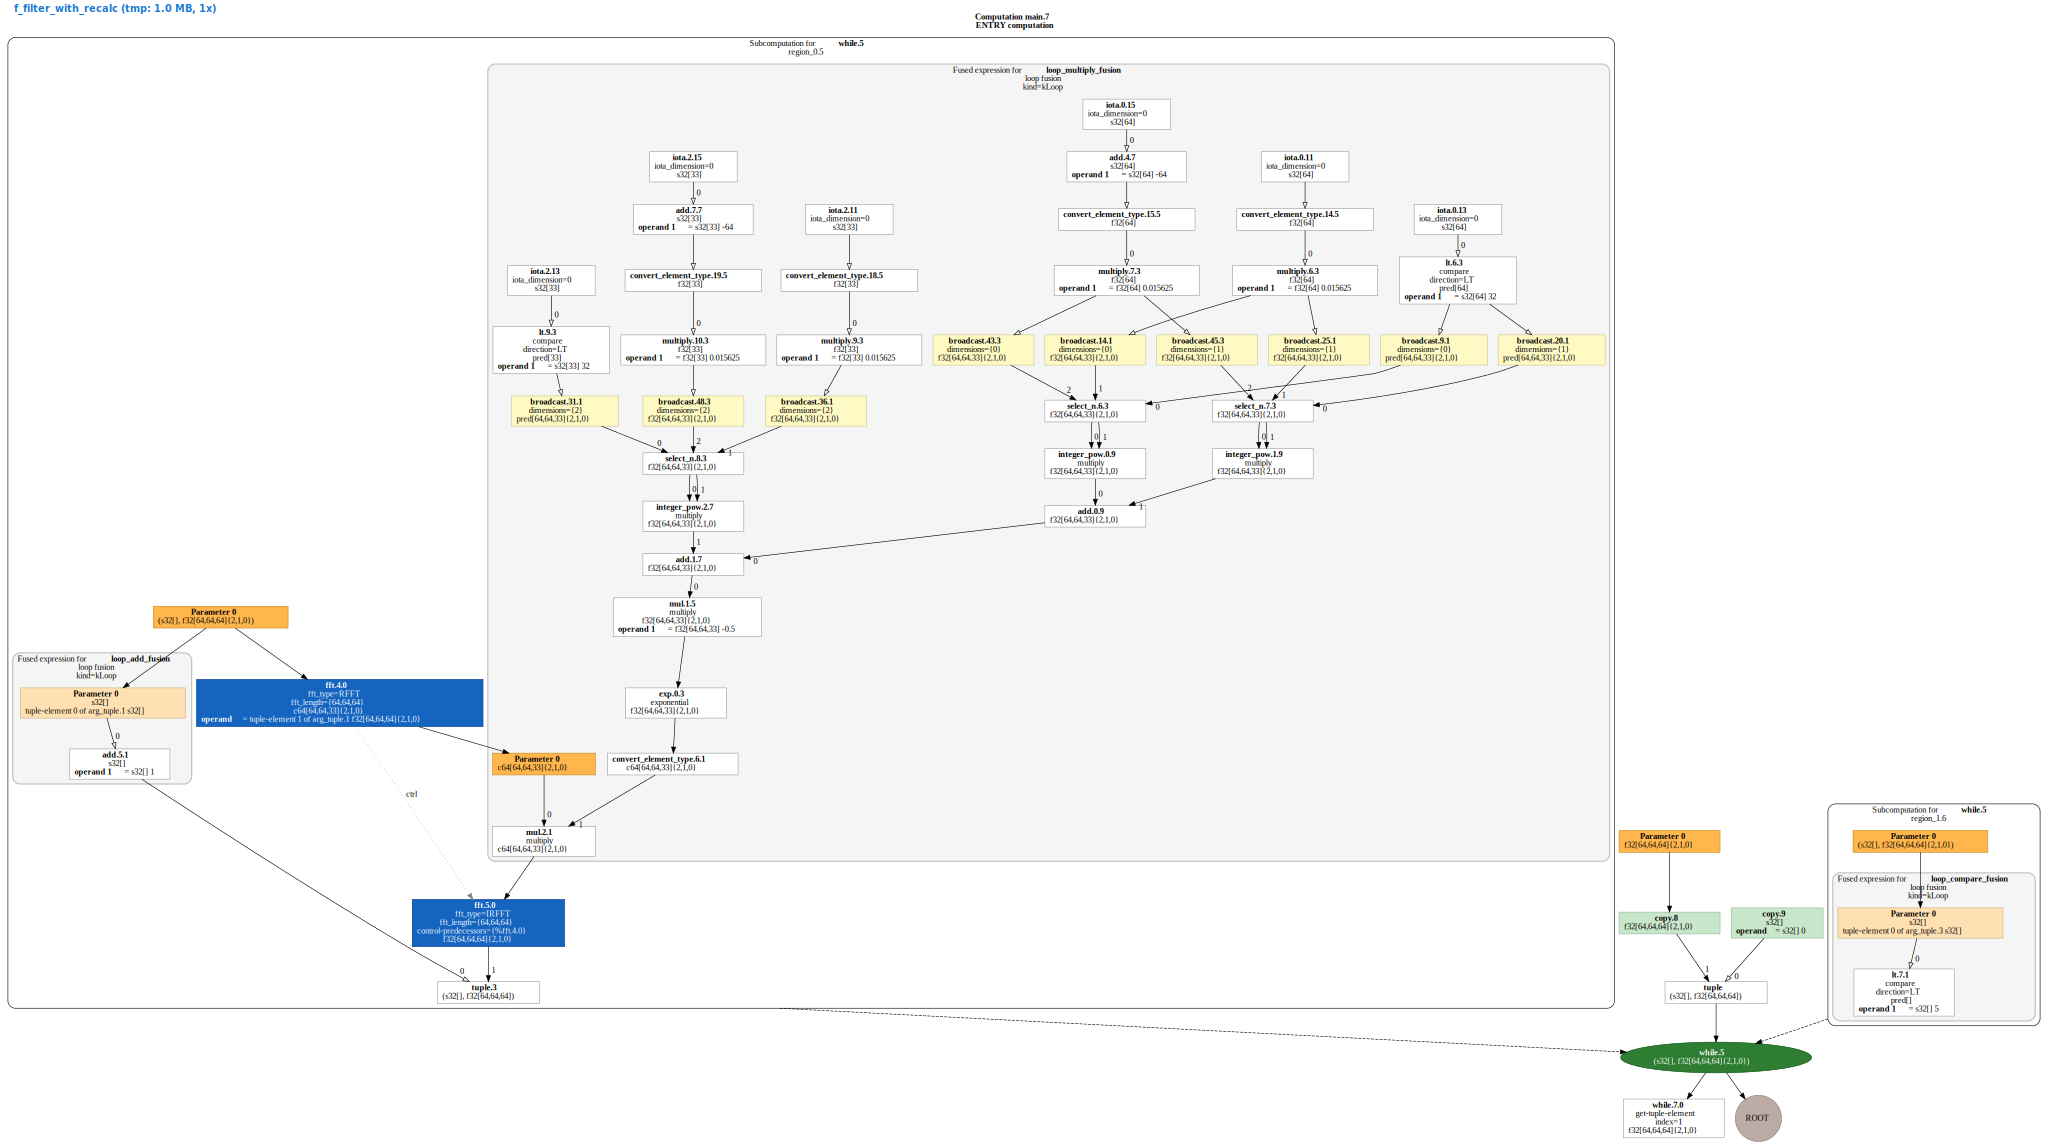

--------  Memory usage of f_filter_with_recalc_naive  ---------
code  : 11.3 kB
temp  : 1.0 MB
arg   : 1.0 MB
output: 1.0 MB
alias : 0 B
peak  : 3.0 MB


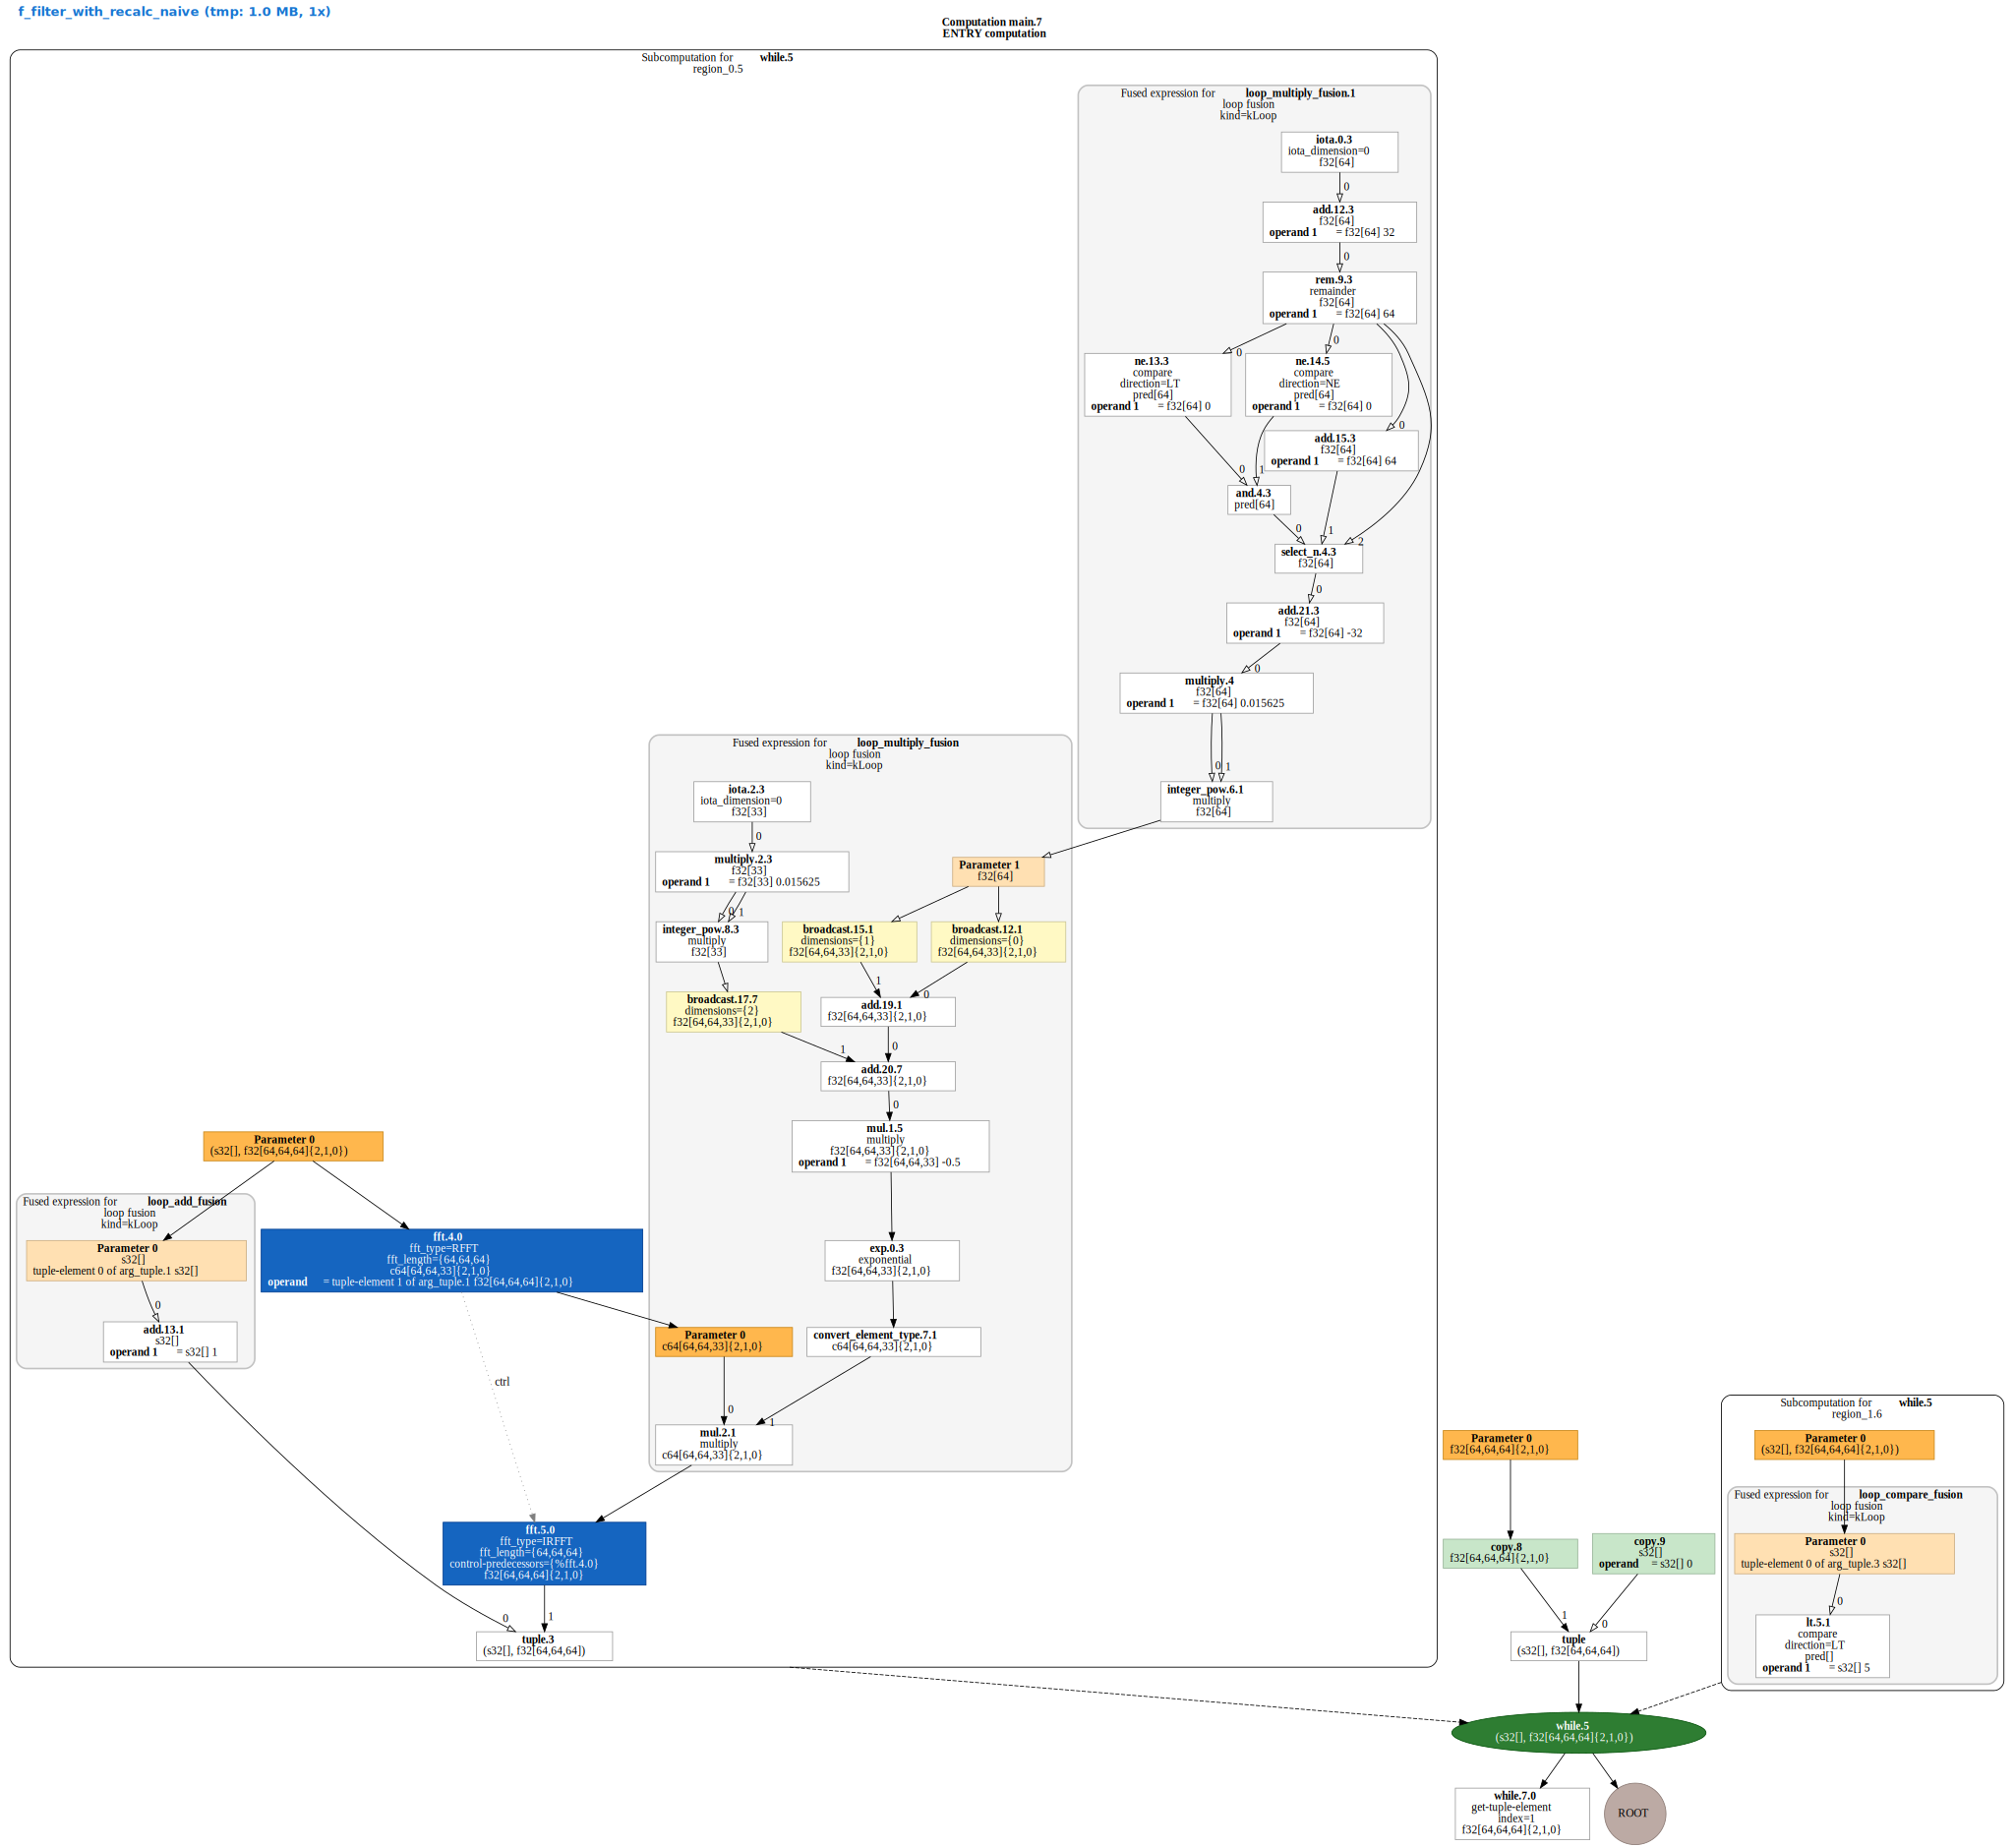

In [12]:
def f_filter_with_temp(rho):
    """If we define a variable outside the loop, it will be stored as a temporary
    
    This is confusing, because usually XLA would determine that k2 is worth recalculating.
    It seems likely that XLA assumes that all variables that are defined outside of the loop
    should not be treated as a graph, but as a constant
    """
    k2 = get_kmesh(rho, norm2=True)

    def step(i, rho):
        rhok = jnp.fft.rfftn(rho, axes=(0,1,2))
        rhok *= jnp.exp(-0.5 * k2)
        return jnp.fft.irfftn(rhok, axes=(0,1,2))

    return jax.lax.fori_loop(0, 5, step, rho)

def f_filter_with_recalc(rho):
    """Triggers recalculation and everything gets fused into one kernel -- optimal!"""
    def step(i, rho):
        rhok = jnp.fft.rfftn(rho, axes=(0,1,2))
        rhok *= jnp.exp(-0.5 * get_kmesh(rho, norm2=True))
        return jnp.fft.irfftn(rhok, axes=(0,1,2))

    return jax.lax.fori_loop(0, 5, step, rho)

def f_filter_with_recalc_naive(rho):
    """This triggers recalculation -- but requires 2 kernel launches in the loop
    surprisingly the memory usage is not worse than in the better implementation above
    """
    def step(i, rho):
        rhok = jnp.fft.rfftn(rho, axes=(0,1,2))
        rhok *= jnp.exp(-0.5 * get_kmesh_naive(rho, norm2=True))
        return jnp.fft.irfftn(rhok, axes=(0,1,2))

    return jax.lax.fori_loop(0, 5, step, rho)

show_hlo_info(jax.jit(f_filter_with_temp), jnp.zeros((64,64,64)), width=800)
show_hlo_info(jax.jit(f_filter_with_recalc), jnp.zeros((64,64,64)), width=800)
show_hlo_info(jax.jit(f_filter_with_recalc_naive), jnp.zeros((64,64,64)), width=800)

# Constant folding

--------  Memory usage of f_numpy  ---------
Warning! We have constant folding!
code  : 128.0 MB
temp  : 0 B
arg   : 128.0 MB
output: 128.0 MB
alias : 0 B
peak  : 384.0 MB


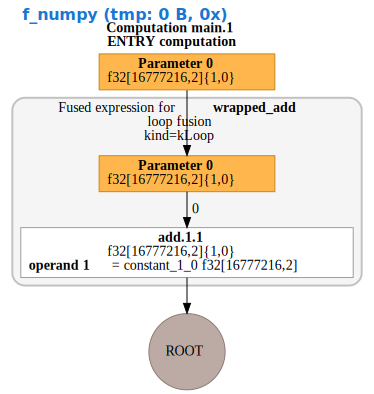

--------  Memory usage of f  ---------
code  : 7.5 kB
temp  : 0 B
arg   : 128.0 MB
output: 128.0 MB
alias : 0 B
peak  : 256.0 MB


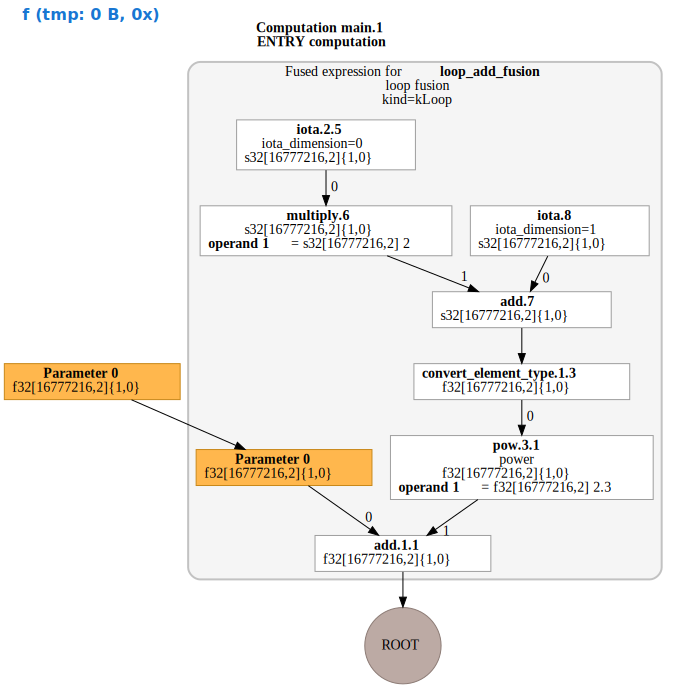

In [13]:
import numpy as np
def f_numpy(x):
    """Folded constants appear as 'code_size' in the memory report. They live in device memory 
    space and they contribute to peak memory! Also they absolutely obliterate the compilation time!
    """
    return x + np.arange(x.size).reshape(x.shape) ** 2.3

def f(x):
    return x + jnp.arange(x.size).reshape(x.shape) ** 2.3

x2 = jnp.zeros((1024*1024*16,2)) # Our probe array -- it uses 1MB
show_hlo_info(jax.jit(f_numpy), x2) # np array gets always folded
show_hlo_info(jax.jit(f), x2)

# End

# Constant folding bug:
Here is a bug I found in my experiments, I wrote a bug report on jax's github

In [14]:
# If I understand this: https://docs.jax.dev/en/latest/internals/constants.html?utm_source=chatgpt.com
# correctly, than I'd think that "potential" constants created through jax.numpy should never be folded

import jax
import jax.numpy as jnp

def f_arange_fine(x):
    return x + jnp.arange(0, x.size).reshape(x.shape)

def f_arange_bug(x):
    return x + jnp.arange(1, x.size+1).reshape(x.shape)

x = jnp.zeros((1024*32,2))
print(jax.make_jaxpr(f_arange_fine)(x))
print(jax.make_jaxpr(f_arange_bug)(x))

{ lambda ; a:f32[32768,2]. let
    b:i32[65536] = iota[dimension=0 dtype=int32 shape=(65536,) sharding=None] 
    c:i32[32768,2] = reshape[dimensions=None new_sizes=(32768, 2) sharding=None] b
    d:f32[32768,2] = convert_element_type[new_dtype=float32 weak_type=False] c
    e:f32[32768,2] = add a d
  in (e,) }
{ lambda a:i32[65536]; b:f32[32768,2]. let
    c:i32[32768,2] = reshape[dimensions=None new_sizes=(32768, 2) sharding=None] a
    d:f32[32768,2] = convert_element_type[new_dtype=float32 weak_type=False] c
    e:f32[32768,2] = add b d
  in (e,) }


# Intermediate recalculation question

In [15]:
def f_recalc(x):
    get_im = lambda x: jnp.exp(jnp.arange(x.size).reshape(x.shape) ** 2.3)

    # I use a jnp.sum here as a fusion barrier to create two different kernels
    # Imagine this represents a long computation with many barriers
    a = x + jnp.sum(x * get_im(x), axis=-1, keepdims=True) 

    # We reuse the same expression here, does it get recalculated or will jax create a temporary intermediate array?
    # (In this function it recalculates it)
    return a + get_im(x) 

def f_stored(x):
    get_im = lambda x: jnp.sin(jnp.arange(x.size).reshape(x.shape) ** 2.3)

    a = x + jnp.sum(get_im(x), axis=-1, keepdims=True) 
 
    # here get_im(x) gets saved and reused as a temporary device array
    # (thanks to the subtle difference of using sin instead of exp)
    return a + get_im(x) 

x = jnp.zeros((1024*128,2))
comp1 = jax.jit(f_recalc).lower(x).compile()
comp2 = jax.jit(f_stored).lower(x).compile()

def create_svg(f_lowered, filename):
    from jaxlib import xla_client as xc
    from graphviz import Source
    from IPython.display import SVG

    mod = xc._xla.hlo_module_from_text(f_lowered.as_text())
    dot = xc._xla.hlo_module_to_dot_graph(mod)
    svg_text = Source(dot).pipe(format="svg").decode("utf-8")
    with open(filename, "w") as f:
        f.write(svg_text)

# create_svg(comp1, filename="f_recalc.svg")
# create_svg(comp2, filename="f_stored.svg")